In [3]:
import datetime
import numpy as np
import pandas as pd
from sklearn.linear_model import *
from sklearn.preprocessing import OneHotEncoder
# from dataProcessingHelpers import sliding_window
from numpy.lib.stride_tricks import sliding_window_view
import os
from glob import glob
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Transformer
import wradlib as wrl

In [4]:
GD_dirname = '../Experiments'

# Radar data
df_radar_1 = np.load(f'../Radar - runoff/40x40radar_echo_2km.pkl', allow_pickle=True)
df_radar_2 = np.load(f'../Radar - runoff/40x40radar_echo_1_25km.pkl', allow_pickle=True)



<AxesSubplot:xlabel='TIMI'>

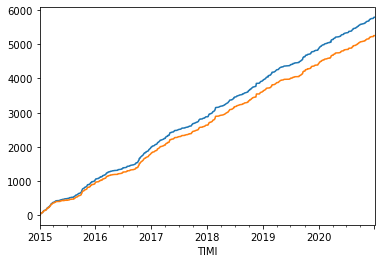

In [5]:
# rain_gauge data
df_gauge = pd.read_pickle(f'{GD_dirname}/Data/rain_gauges_combined.pkl')    
raw_columns = [col for col in df_gauge.columns if 'raw' in col]
df_gauge.loc[:,raw_columns] = df_gauge.loc[:,raw_columns]
good_sensors = ['1475','1473','1481']
df_gauge = df_gauge.loc[:,[i for i in df_gauge.columns if any([ID in i for ID in good_sensors])]]


d_start = datetime.datetime(2015,1,1)
# d_end = datetime.datetime(2020,1,1)
d_end = datetime.datetime(2021,1,1)
df_gauge.loc[d_start:d_end,'1475_R_raw'].cumsum().plot()
df_gauge.loc[d_start:d_end,'1475_R_manual'].cumsum().plot()

In [6]:
coords = np.load('../Radar processing/CAPPI_pixel_coords.npy')

In [7]:
URL_gauge_data = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges/'


In [8]:
# glob(URL_gauge_data + '*')

In [9]:
df_meta_gauge = np.load(URL_gauge_data + 'sensor_info.npy',allow_pickle=True)
df_meta_gauge = pd.DataFrame(df_meta_gauge,columns = ['Nafn','gerð','nr','nr2','nafn_stutt','svæði','GPS','hæð','ár','Eign','x','y'])
df_meta_gauge.loc[:,'x'] = df_meta_gauge.loc[:,'x'].astype(float)
df_meta_gauge.loc[:,'y'] = df_meta_gauge.loc[:,'y'].astype(float)
df_meta_gauge = df_meta_gauge.drop([14,10],axis=0)
df_meta_gauge.loc[6,'nr'] = '1475'
df_meta_gauge = df_meta_gauge.loc[df_meta_gauge.loc[:,'nr'].isin(good_sensors)]
df_meta_gauge

,Nafn,gerð,nr,nr2,nafn_stutt,svæði,GPS,hæð,ár,Eign,x,y
5,Hólmsheiði,Sjálfvirk veðurathugunarstöð,1481,4920,holms,Faxaflói(fa),"64°06.510', 21°41.182' (64,1085, 21,6864)",130.0 m.y.s.,2006,Veðurstofa Íslands,64.1085,21.6864
6,Reykjavík búveðurstöð,Sjálfvirk veðurathugunarstöð,1475,4930,reits,Faxaflói(fa),"64°07.646', 21°54.146' (64,1274, 21,9024)",52.0 m.y.s.,2000,Veðurstofa Íslands,64.1274,21.9024
12,Straumsvík,Sjálfvirk veðurathugunarstöð,1473,4124,strau,Faxaflói(fa),"64°02.628', 22°02.427' (64,0438, 22,0404)",7.0 m.y.s.,2001,Veðurstofa Íslands,64.0438,22.0404


In [10]:
sitecoords = (-22.636, 64.025, 45.0)

postnr = gpd.read_file('../Radar data analysis/Radar visualization/Shapefiles/postnr/postnrs.shp')
coords = np.load('../Radar processing/CAPPI_pixel_coords.npy')

transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit

radar_x,radar_y = transformer_gps_isl.transform(sitecoords[1],sitecoords[0])
main_gauge_x,main_gauge_y = transformer_gps_isl.transform(64.1275,-21.902)


def get_idx_from_coords(coords,gauge_x,gauge_y):
        
    pixel_distance = ((coords[:,:2] - [gauge_x,gauge_y])**2).sum(axis=1)**0.5
    idx_closest_pixel = pixel_distance.argmin()
    pixel_distance[idx_closest_pixel],idx_closest_pixel
    gauge_idx,gauge_idy = idx_closest_pixel//602,idx_closest_pixel%602
    return gauge_idx,gauge_idy


main_gauge_idx,main_gauge_idy = get_idx_from_coords(coords,main_gauge_x,main_gauge_y)
print(main_gauge_idx,main_gauge_idy)

312 344


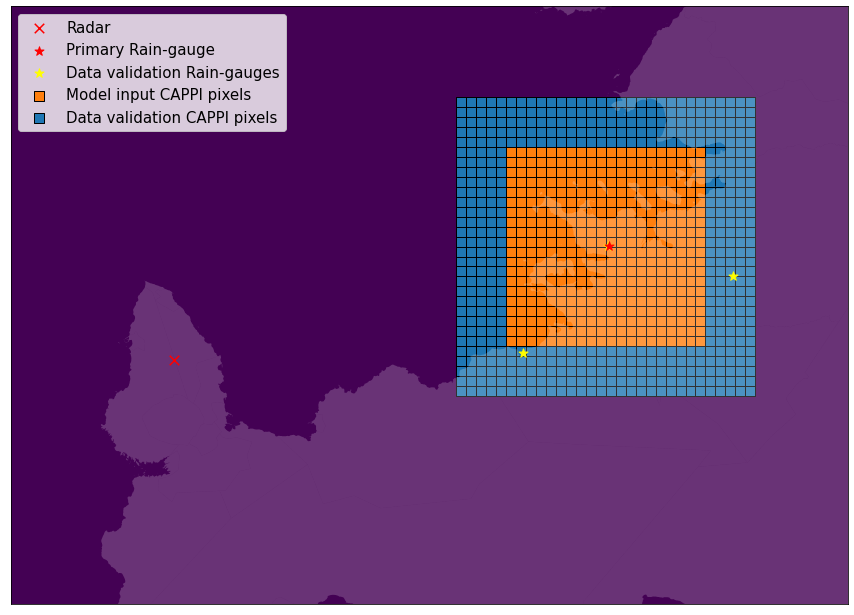

In [11]:
margin_extra = 15
margin = 10
# margin = 30

CAPPI_indexes = np.arange(602**2).reshape(602,602)

cappi_idx_extra = CAPPI_indexes[main_gauge_idx-margin_extra:main_gauge_idx+margin_extra,main_gauge_idy-margin_extra:main_gauge_idy+margin_extra].ravel()
cappi_idx = CAPPI_indexes[main_gauge_idx-margin:main_gauge_idx+margin,main_gauge_idy-margin:main_gauge_idy+margin].ravel()

plt.figure(figsize=(15,15))
pixels_handle_extra = plt.scatter(coords[cappi_idx_extra,0],coords[cappi_idx_extra,1],s = 100,marker = 's',edgecolors='black')
pixels_handle = plt.scatter(coords[cappi_idx,0],coords[cappi_idx,1],s = 100,marker = 's',edgecolors='black')

postnr.geometry.plot(ax = plt.gca(),alpha = 0.2,color='white')

radar_handle = plt.scatter(radar_x,radar_y,c ='red',marker = 'x',s = 90)

pixel_idx = []
for index,row in df_meta_gauge.iterrows():
    gauge_x,gauge_y = transformer_gps_isl.transform(row['x'],-row['y'])
    gauge_handle_extra = plt.scatter(gauge_x,gauge_y,c ='yellow',marker = '*',s = 90)
    gauge_idx,gauge_idy = get_idx_from_coords(coords,gauge_x,gauge_y)
    pixel_idx.append((gauge_idx,gauge_idy))
    
    
gauge_handle = plt.scatter(main_gauge_x,main_gauge_y,c ='red',marker = '*',s = 90)
plt.ylim(main_gauge_y - 30_000,main_gauge_y + 20_000)
plt.xlim(main_gauge_x - 50_000,main_gauge_x + 20_000)
plt.xticks([],[])
plt.yticks([],[])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
# plt.title('Data overview',fontsize=25)
plt.legend([radar_handle,gauge_handle,gauge_handle_extra,pixels_handle,pixels_handle_extra],['Radar','Primary Rain-gauge','Data validation Rain-gauges','Model input CAPPI pixels','Data validation CAPPI pixels'],loc = 'upper left',fontsize=15)
plt.show()

# Visualize with closest pixel

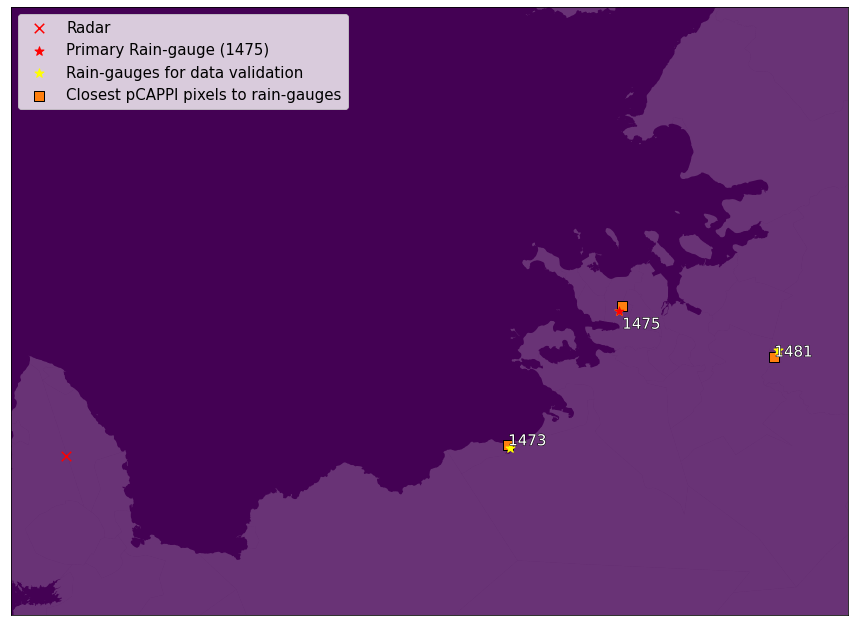

In [12]:
import matplotlib.patheffects as PathEffects

margin_extra = 20
margin = 10
# margin = 30

CAPPI_indexes = np.arange(602**2).reshape(602,602)

cappi_idx_extra = CAPPI_indexes[main_gauge_idx-margin_extra:main_gauge_idx+margin_extra,main_gauge_idy-margin_extra:main_gauge_idy+margin_extra].ravel()
cappi_idx = CAPPI_indexes[main_gauge_idx-margin:main_gauge_idx+margin,main_gauge_idy-margin:main_gauge_idy+margin].ravel()

plt.figure(figsize=(15,15))
# pixels_handle_extra = plt.scatter(coords[cappi_idx_extra,0],coords[cappi_idx_extra,1],s = 100,marker = 's',edgecolors='black')

postnr.geometry.plot(ax = plt.gca(),alpha = 0.2,color='white')

radar_handle = plt.scatter(radar_x,radar_y,c ='red',marker = 'x',s = 90)

gauge_cappi_pixel_coords = []
for i,(x,y) in enumerate(pixel_idx):
    cappi_pixel_coord = CAPPI_indexes[x,y]
    gauge_cappi_pixel_coords.append(cappi_pixel_coord)
    x_c,y_c = coords[CAPPI_indexes[x,y],0],coords[CAPPI_indexes[x,y],1]
    closest_pixel = plt.scatter(x_c,y_c,s = 100,marker = 's',edgecolors='black',color='#ff7f0e')
    s = df_meta_gauge.iloc[i,2]
    if s in ['1868','1779','1490','1493']:
        continue
    if s in ['1475']:
        y_c = y_c - 1500
        # x_c = x_c + 700
    txt = plt.text(x_c,y_c,s,fontsize = 15,color='white')
    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='black')])
    
for index,row in df_meta_gauge.iterrows():
    gauge_x,gauge_y = transformer_gps_isl.transform(row['x'],-row['y'])
    gauge_handle_extra = plt.scatter(gauge_x,gauge_y,c ='yellow',marker = '*',s = 90)
    
gauge_handle = plt.scatter(main_gauge_x,main_gauge_y,c ='red',marker = '*',s = 90)
plt.ylim(main_gauge_y - 20_000,main_gauge_y + 20_000)
plt.xlim(main_gauge_x - 40_000,main_gauge_x + 15_000)
plt.xticks([],[])
plt.yticks([],[])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
# plt.title('Data overview',fontsize=25)
plt.legend([radar_handle,
            gauge_handle,
            gauge_handle_extra,
            # pixels_handle_extra,
            closest_pixel],
           ['Radar',
            'Primary Rain-gauge (1475)',
            'Rain-gauges for data validation',
            # 'Data validation Rain-gauges',
            # '40x40 grid of CAPPI pixels around the Capital Region of Iceland',
            'Closest pCAPPI pixels to rain-gauges'],loc = 'upper left',fontsize=15)
plt.show()

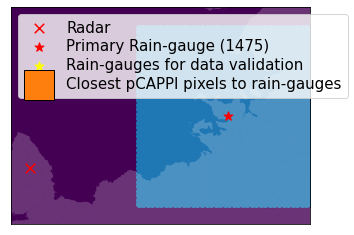

In [86]:
plt.scatter(coords[cappi_idx_extra][:,0],coords[cappi_idx_extra][:,1])

postnr.geometry.plot(ax = plt.gca(),alpha = 0.2,color='white')

radar_handle = plt.scatter(radar_x,radar_y,c ='red',marker = 'x',s = 90)

gauge_handle = plt.scatter(main_gauge_x,main_gauge_y,c ='red',marker = '*',s = 90)
plt.ylim(main_gauge_y - 20_000,main_gauge_y + 20_000)
plt.xlim(main_gauge_x - 40_000,main_gauge_x + 15_000)
plt.xticks([],[])
plt.yticks([],[])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
# plt.title('Data overview',fontsize=25)
plt.legend([radar_handle,
            gauge_handle,
            gauge_handle_extra,
            # pixels_handle_extra,
            closest_pixel],
           ['Radar',
            'Primary Rain-gauge (1475)',
            'Rain-gauges for data validation',
            # 'Data validation Rain-gauges',
            # '40x40 grid of CAPPI pixels around the Capital Region of Iceland',
            'Closest pCAPPI pixels to rain-gauges'],loc = 'upper left',fontsize=15)
plt.show()

In [79]:
cappi_data_coords = {}
for i,gauge_pixel_coords in enumerate(gauge_cappi_pixel_coords):
    if gauge_pixel_coords not in cappi_idx_extra.ravel():
        continue
    else:
        relative_coords = np.argwhere(cappi_idx_extra.ravel() == gauge_pixel_coords)
        
        gauge_id = df_meta_gauge.iloc[i,2]
        cappi_data_coords[gauge_id] = relative_coords[0,0]
        

In [67]:
cappi_data_coords = {}
for i,gauge_pixel_coords in enumerate(gauge_cappi_pixel_coords):
    # if gauge_pixel_coords not in NWP_idx_extra.ravel():
    #     continue
    # else:
    relative_coords = np.argwhere(cappi_idx_extra.ravel() == gauge_pixel_coords)
    gauge_id = df_meta_gauge.iloc[i,2]
    cappi_data_coords[gauge_id] = relative_coords[0,0]

In [80]:
cappi_data_coords

{'1481': 672, '1475': 820, '1473': 371}

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

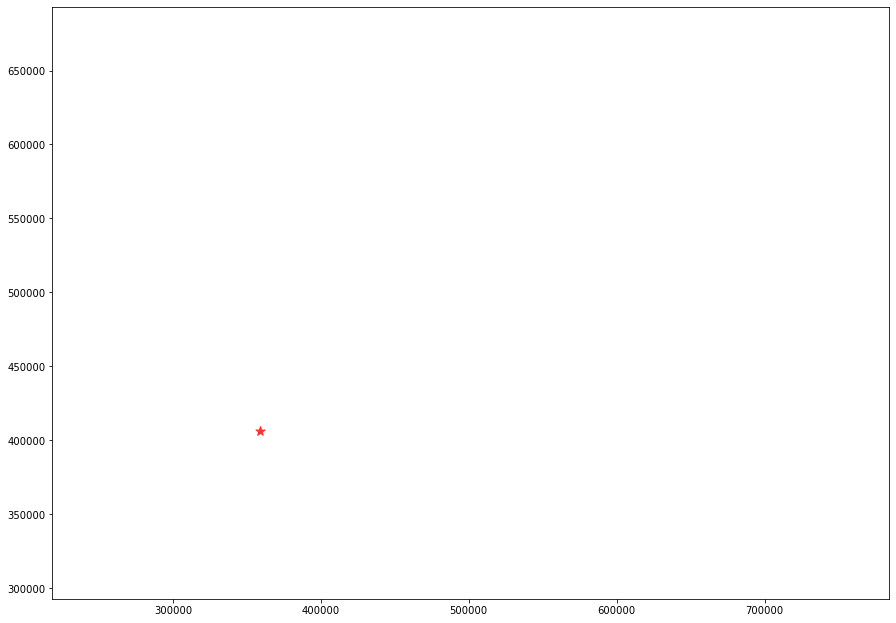

In [70]:
plt.figure(figsize=(15,15))
gauge_handle = plt.scatter(main_gauge_x,main_gauge_y,c ='red',marker = '*',s = 90)
postnr.geometry.plot(ax = plt.gca(),alpha = 0.2,color='white')
for i in cappi_data_coords.values():
    x_c,y_c = coords[CAPPI_indexes[x,y],0],coords[CAPPI_indexes[x,y],1]
    closest_pixel = plt.scatter(x_c,y_c,s = 900,marker = 's',edgecolors='black',color='#ff7f0e')

plt.ylim(main_gauge_y - 30_000,main_gauge_y + 20_000)
plt.xlim(main_gauge_x - 50_000,main_gauge_x + 20_000)
plt.xticks([],[])
plt.yticks([],[])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
# plt.title('Data overview - NWP',fontsize=25)
plt.legend([radar_handle,gauge_handle,gauge_handle_extra,pixels_handle],
           ['Radar','Primary Rain-gauge','Data validation Rain-gauges','NWP pixels\n'],
           loc = 'upper left',
           fontsize=15,
           borderpad=0.3)
plt.rcParams.update({'legend.labelspacing':0.25})
plt.show()

In [14]:
df_gauge.apply(lambda x : x.dropna().index.min())

STOD
1473_R_manual   2015-01-01
1475_R_manual   2015-01-01
1473_R_raw      2015-01-01
1475_R_raw      2015-01-01
1481_R_raw      2015-01-01
dtype: datetime64[ns]

<AxesSubplot:>

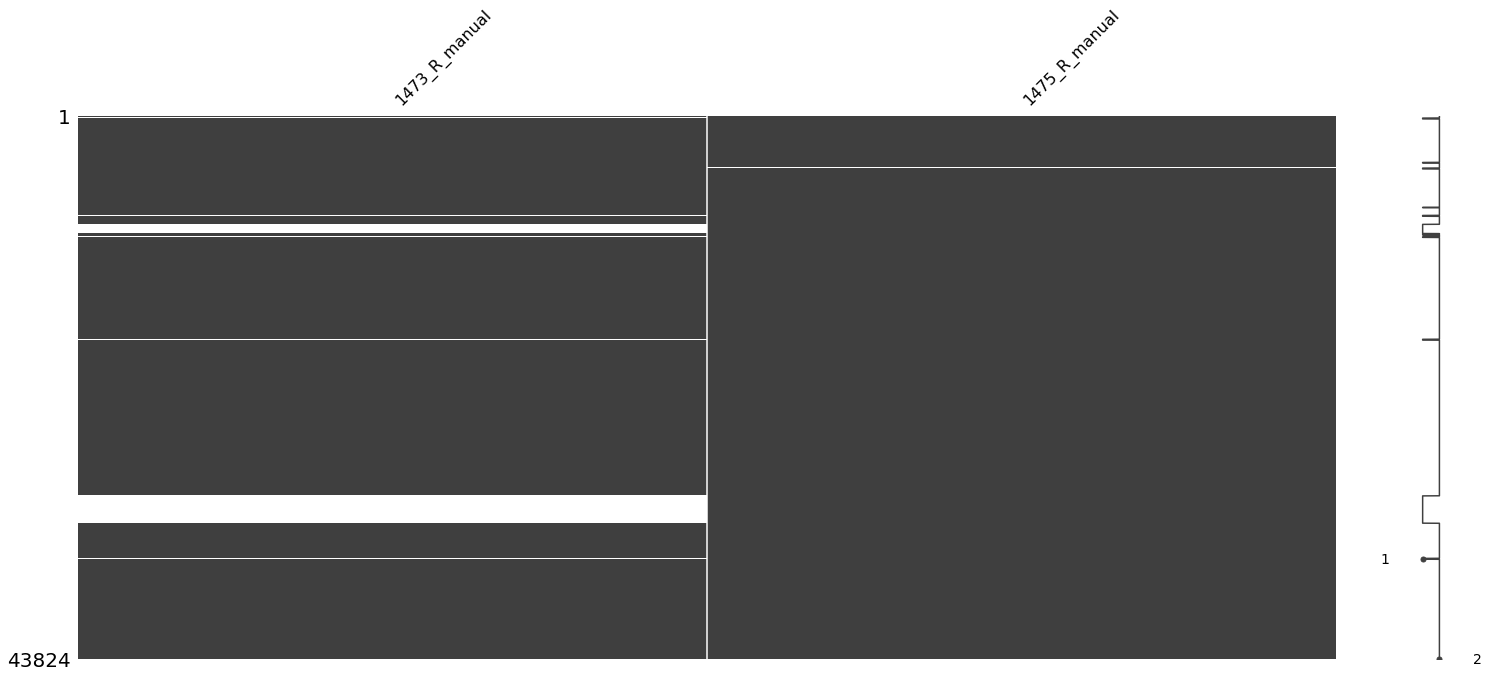

In [15]:
from missingno import matrix
d_start = datetime.datetime(2015,1,1)
d_end = datetime.datetime(2019,12,31,23,59,59)
# d_start = datetime.datetime(2015,5,1)
# d_end = datetime.datetime(2015,7,1)
matrix(df_gauge.loc[d_start:d_end,[col for col in df_gauge.columns if 'manual' in col]])

In [16]:
# df_radar_subset = df_radar.loc[:,cappi_data_coords.values()]
# df_radar_subset.columns = cappi_data_coords.keys()

df_radar_1_subset = df_radar_1.loc[:,cappi_data_coords.values()]
df_radar_1_subset.columns = cappi_data_coords.keys()

df_radar_2_subset = df_radar_2.loc[:,cappi_data_coords.values()]
df_radar_2_subset.columns = cappi_data_coords.keys()

In [17]:
# df_radar_subset_dirty_interpolation = df_radar_subset.resample('300s').mean()#.interpolate()
df_radar_1_subset_dirty_interpolation = df_radar_1_subset#.resample('300s').mean()#.interpolate()
df_radar_2_subset_dirty_interpolation = df_radar_2_subset#.resample('300s').mean()#.interpolate()

# get full resolution gauge data

In [18]:
df_radar_2_subset_dirty_interpolation

,1481,1475,1473
2015-01-01 00:00:00,3.2,11.6,-21.2
2015-01-01 00:15:00,-1.6,12.8,-21.6
2015-01-01 00:30:00,-25.2,14.0,14.0
2015-01-01 00:45:00,1.6,14.4,14.8
2015-01-01 01:00:00,-14.8,11.2,14.8
...,...,...,...
2019-12-31 23:35:00,-21.0,-6.5,-32.0
2019-12-31 23:40:00,4.5,-28.5,-32.0
2019-12-31 23:45:00,-32.0,-11.0,-23.0
2019-12-31 23:50:00,10.5,-16.5,-32.0


In [19]:
def to_rainfall(radar_data,a,b):
    rainfall = wrl.zr.z_to_r(wrl.trafo.idecibel(radar_data), a=a, b=b)
    return rainfall

In [20]:
import re
from glob import glob
DIR_rain_gauges = glob(URL_gauge_data + '*cleaned*')
# Rain gauges - Review processing of this data before proceeding 
rain_gauage_ids = [re.findall('[0-9][0-9][0-9][0-9]',i)[0] for i in DIR_rain_gauges]
gauges_raw = pd.DataFrame([pd.read_pickle(i) for i in DIR_rain_gauges],index = rain_gauage_ids).T.rename(lambda x : str(x) + '_R_raw',axis=1).sort_index()
# gauges_raw_hour = gauges_raw.resample('1h').sum()

In [21]:
x_rad = df_radar_2_subset_dirty_interpolation.loc[:,'1475']
# x_gau = df_gauge.loc[:,'1475_R_manual']
x_gau = gauges_raw.loc[:,'1475_R_raw']
def get_corr(ab):
    a,b = ab
    # resample_freq = '1800s'
    resample_freq = '1h'
    x_rad_R = to_rainfall(x_rad,a,b).resample('900s').mean().shift(4).resample('1h').mean()
    x_gau_R = x_gau.shift(0).resample(resample_freq).mean()
    
    common_index = x_rad_R.dropna().index.intersection(x_gau.dropna().index)

    metrics_raw = wrl.verify.ErrorMetrics(x_rad_R.loc[common_index].values,x_gau.loc[common_index].values)
    # metrics_raw.pprint()
    # corr = np.corrcoef(x_rad_R.loc[common_index].values,x_gau.loc[common_index].values)[0,1]
    mse = ((x_rad_R.loc[common_index].values - x_gau.loc[common_index].values)**2).mean()
    # n_corr = -corr
    
    # nash = metrics_raw.nash()
    # n_corr = -metrics_raw.corr()
    # print(ab,n_corr)
    print(mse)
    return mse

from scipy.optimize import minimize
corr_from_coeff = lambda x : get_corr(x[0],x[1])

minimize(get_corr,(200,1.6))

0.1245348913427089
0.1245348913427089
0.12453489133596485
0.1245348906272205
0.12249164990995677
0.12249164990995677
0.12249164990360109
0.1224916493522448
0.11942583862594962
0.11942583862594962
0.11942583862026272
0.11942583833699894
0.11795096010016533
0.11795096010016533
0.11795096009495978
0.11795096000622685
0.11773115259909196
0.11773115259909196
0.117731152594058
0.11773115257665878
0.11771613427487312
0.11771613427487312
0.11771613426988685
0.11771613427267426
0.11771584671598333
0.11771584671598333
0.1177158467110025
0.11771584671611002
0.11771567523956977
0.11771567523956977
0.11771567523459099
0.11771567524054455
0.11771535156327197
0.11771535156327197
0.11771535155829521
0.11771535156510379
0.11771473287250488
0.11771473287250488
0.11771473286753069
0.11771473287540128
0.11771355137516605
0.11771355137516605
0.11771355137019558
0.11771355137954356
0.11771131587704722
0.11771131587704722
0.11771131587208235
0.11771131588362296
0.11770716118301222
0.11770716118301222
0.11770

      fun: 0.06203808418339719
 hess_inv: array([[1.65716509e+11, 7.41573510e+06],
       [7.41573510e+06, 5.38942199e+02]])
      jac: array([0.00000000e+00, 1.23213977e-06])
  message: 'Optimization terminated successfully.'
     nfev: 220
      nit: 50
     njev: 55
   status: 0
  success: True
        x: array([8.32632707e+03, 1.94891174e+00])

In [22]:
def get_mse(ab,name_1,name_2,d1,d2,df_rad):
    a,b = ab
    x_gau = df_gauge.loc[d1:d2,name_1]
    x_rad = df_rad.loc[d1:d2,name_2]
    x_rad_R = to_rainfall(x_rad.loc[d1:d2],a,b).resample('900s').mean().shift(4).resample('1h').mean()
    common_index = x_rad_R.dropna().index.intersection(x_gau.dropna().index)
    mse = ((x_rad_R.loc[common_index].values - x_gau.loc[common_index].values)**2).mean()
    
    return mse

In [23]:
from sklearn.metrics import r2_score,mean_squared_error

periods = [
    (datetime.datetime(2015,1,1), datetime.datetime(2018,3,1)),
    (datetime.datetime(2018,3,1),datetime.datetime(2019,12,31)),
    (datetime.datetime(2015,1,1),datetime.datetime(2019,12,31))
]

metrics = [('MSE',lambda x1,x2 : mean_squared_error(x1,x2)),
           ('correlation',lambda x1,x2 : np.corrcoef(x1,x2)[0,1]),
        #    ('R2',lambda x1,x2 : r2_score(x1,x2))
           ]

sensors = [('1475_R_manual','1475'),
           ('1473_R_manual','1473'),
           ('1481_R_raw','1481')]

,1481,1475,1473
2015-01-01 00:00:00,4.4,6.8,-19.6
2015-01-01 00:15:00,-24.8,0.0,-14.8
2015-01-01 00:30:00,-30.0,7.6,9.2
2015-01-01 00:45:00,-2.0,15.2,13.2
2015-01-01 01:00:00,3.2,10.4,9.2
...,...,...,...
2019-12-31 23:35:00,-32.0,-23.0,-32.0
2019-12-31 23:40:00,-32.0,-32.0,-18.5
2019-12-31 23:45:00,-32.0,-25.0,-15.5
2019-12-31 23:50:00,8.0,-7.0,-15.0


In [24]:
results_list = {}
for p1,p2 in periods:
    
    for s1,s2 in sensors:
        # compute optimal w.r.t. MSE
        min_results_1_25km = minimize(lambda x : get_mse(x,s1,s2,p1,p2,df_radar_1_subset_dirty_interpolation),
                                      (200,1.6),
                                      bounds = [(0,1000),(0.1,5)]
                                      )
        min_results_2km = minimize(lambda x : get_mse(x,s1,s2,p1,p2,df_radar_2_subset_dirty_interpolation),
                                   (200,1.6),
                                   bounds = [(0,1000),(1,5)]
                                   )
        a_1_25,b_1_25 = min_results_1_25km.x
        a_2,b_2  = min_results_2km.x
        # a_1_25,b_1_25 = 200,2
        # a_2,b_2  = 200,2
        print(p1,s2)
        print(a_1_25,b_1_25)
        print(a_2,b_2)
        
        x_gau = df_gauge.loc[p1:p2,s1]
        x_rad_1 = df_radar_1_subset_dirty_interpolation.loc[:,s2]
        x_rad_2 = df_radar_2_subset_dirty_interpolation.loc[:,s2]
        x_rad_R1d = to_rainfall(x_rad_1.loc[p1:p2],200,1.6).resample('900s').mean().shift(4).resample('1h').mean()
        x_rad_R2d = to_rainfall(x_rad_2.loc[p1:p2],200,1.6).resample('900s').mean().shift(4).resample('1h').mean()
        
        x_rad_R1o = to_rainfall(x_rad_1.loc[p1:p2],a_1_25,b_1_25).resample('900s').mean().shift(4).resample('1h').mean() 
        x_rad_R2o = to_rainfall(x_rad_2.loc[p1:p2],a_2,b_2).resample('900s').mean().shift(4).resample('1h').mean()
        
        common_index_1 = x_rad_R1o.dropna().index.intersection(x_gau.dropna().index)
        common_index_2 = x_rad_R2o.dropna().index.intersection(x_gau.dropna().index)
        
        for metric_name,metric in metrics:
            # print(p1,p2,metric_name,s1)
            results_list[(p1.strftime('%b-%Y'),p2.strftime('%b-%Y'),metric_name,s1,'a=200,b=1.6','2km')] = metric(x_rad_R1d.loc[common_index_1],x_gau.loc[common_index_1])
            results_list[(p1.strftime('%b-%Y'),p2.strftime('%b-%Y'),metric_name,s1,f'a={a_1_25.round(2)},b={b_1_25.round(2)}','2km')] = metric(x_rad_R1o.loc[common_index_1],x_gau.loc[common_index_1])
            results_list[(p1.strftime('%b-%Y'),p2.strftime('%b-%Y'),metric_name,s1,'a=200,b=1.6','1.25km')] = metric(x_rad_R2d.loc[common_index_2],x_gau.loc[common_index_2])
            results_list[(p1.strftime('%b-%Y'),p2.strftime('%b-%Y'),metric_name,s1,f'a={a_1_25.round(2)},b={b_1_25.round(2)}','1.25km')] = metric(x_rad_R2o.loc[common_index_2],x_gau.loc[common_index_2])
            

2015-01-01 00:00:00 1475
86.76929240909593 2.1446925603993776
332.9002072794713 1.654322800972557
2015-01-01 00:00:00 1473
200.00314777687797 2.7055098285542956
347.07696398134146 2.6860276358424797
2015-01-01 00:00:00 1481
90.44656529492741 2.9597969558976267
136.91163380794535 2.4397561119291917
2018-03-01 00:00:00 1475
103.94533573367421 2.192299787648569
110.08424257320476 2.077977582162956
2018-03-01 00:00:00 1473
199.98118036763273 3.0204306408713966
200.00218531149497 2.5642477713195824


C:\Users\sverrirhd\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]


2018-03-01 00:00:00 1481
126.03498807207146 1.6518684645632815
78.45266633780011 2.548787033590341
2015-01-01 00:00:00 1475
93.45018351396251 2.17652007232047
262.05894674306217 1.7279895894471273
2015-01-01 00:00:00 1473
199.9963430813278 2.7746565667858367
306.84165710691366 2.683721811382251
2015-01-01 00:00:00 1481
73.42791404484285 2.787806463175417
115.94001059912327 2.4741935845666614


In [25]:
df_results_long = pd.DataFrame(results_list.values(),index = results_list.keys())
df_results_long = df_results_long.reset_index()
df_results_long.columns = ['start_date','end_date','metric','sensor','ZR','CAPPI','val']
df_results_long.loc[:,'period'] = df_results_long.loc[:,'start_date'].values + \
    ' - ' + df_results_long.loc[:,'end_date']
df_results_long = df_results_long.drop(['start_date','end_date'],axis=1)
df_results_long.loc[:,'sensor'] = df_results_long.loc[:,'sensor'].str[:4]

# df_results = df_results_long.pivot_table(values = 'val', index = ['sensor','period'],columns = ['metric','CAPPI','ZR'])
df_results = df_results_long.pivot_table(values = 'val', index = ['CAPPI','period','ZR'],columns = ['metric','sensor'])

In [26]:
df_results

metric                                           MSE                      \
sensor                                          1473      1475      1481   
CAPPI  period              ZR                                              
1.25km Jan-2015 - Dec-2019 a=200,b=1.6      0.061562  0.089115  0.119649   
                           a=200.0,b=2.77   0.051240       NaN       NaN   
                           a=73.43,b=2.79        NaN       NaN  0.107240   
                           a=93.45,b=2.18        NaN  0.086141       NaN   
       Jan-2015 - Mar-2018 a=200,b=1.6      0.067253  0.102428  0.124687   
                           a=200.0,b=2.71   0.053348       NaN       NaN   
                           a=86.77,b=2.14        NaN  0.094283       NaN   
                           a=90.45,b=2.96        NaN       NaN  0.113736   
       Mar-2018 - Dec-2019 a=103.95,b=2.19       NaN  0.060138       NaN   
                           a=126.03,b=1.65       NaN       NaN  0.093769   
                           a=199.98,b=3.02  0.046707       NaN       NaN   
                           a=200,b=1.6      0.050685  0.066498  0.111078   
2km    Jan-2015 - Dec-2019 a=200,b=1.6      0.061456  0.089584  0.142530   
                           a=200.0,b=2.77   0.055642       NaN       NaN   
                           a=73.43,b=2.79        NaN       NaN  0.123102   
                           a=93.45,b=2.18        NaN  0.080036       NaN   
       Jan-2015 - Mar-2018 a=200,b=1.6      0.065046  0.097094  0.155222   
                           a=200.0,b=2.71   0.058209       NaN       NaN   
                           a=86.77,b=2.14        NaN  0.086291       NaN   
                           a=90.45,b=2.96        NaN       NaN  0.133618   
       Mar-2018 - Dec-2019 a=103.95,b=2.19       NaN  0.068903       NaN   
                           a=126.03,b=1.65       NaN       NaN  0.111231   
                           a=199.98,b=3.02  0.050497       NaN       NaN   
                           a=200,b=1.6      0.054460  0.076610  0.120555   

metric                                     correlation                      
sensor                                            1473      1475      1481  
CAPPI  period              ZR                                               
1.25km Jan-2015 - Dec-2019 a=200,b=1.6        0.536610  0.593744  0.592712  
                           a=200.0,b=2.77     0.597333       NaN       NaN  
                           a=73.43,b=2.79          NaN       NaN  0.641636  
                           a=93.45,b=2.18          NaN  0.598544       NaN  
       Jan-2015 - Mar-2018 a=200,b=1.6        0.525398  0.567300  0.586221  
                           a=200.0,b=2.71     0.593815       NaN       NaN  
                           a=86.77,b=2.14          NaN  0.569652       NaN  
                           a=90.45,b=2.96          NaN       NaN  0.628577  
       Mar-2018 - Dec-2019 a=103.95,b=2.19         NaN  0.721780       NaN  
                           a=126.03,b=1.65         NaN       NaN  0.675795  
                           a=199.98,b=3.02    0.611106       NaN       NaN  
                           a=200,b=1.6        0.576689  0.699345  0.609135  
2km    Jan-2015 - Dec-2019 a=200,b=1.6        0.492121  0.606702  0.498128  
                           a=200.0,b=2.77     0.550901       NaN       NaN  
                           a=73.43,b=2.79          NaN       NaN  0.572391  
                           a=93.45,b=2.18          NaN  0.636276       NaN  
       Jan-2015 - Mar-2018 a=200,b=1.6        0.475330  0.588180  0.439741  
                           a=200.0,b=2.71     0.541896       NaN       NaN  
                           a=86.77,b=2.14          NaN  0.615310       NaN  
                           a=90.45,b=2.96          NaN       NaN  0.537765  
       Mar-2018 - Dec-2019 a=103.95,b=2.19         NaN  0.675840       NaN  
                           a=126.03,b=1.65         NaN       NaN  0.622395  
                      

In [27]:
df_results.round(4)

metric                                         MSE                  \
sensor                                        1473    1475    1481   
CAPPI  period              ZR                                        
1.25km Jan-2015 - Dec-2019 a=200,b=1.6      0.0616  0.0891  0.1196   
                           a=200.0,b=2.77   0.0512     NaN     NaN   
                           a=73.43,b=2.79      NaN     NaN  0.1072   
                           a=93.45,b=2.18      NaN  0.0861     NaN   
       Jan-2015 - Mar-2018 a=200,b=1.6      0.0673  0.1024  0.1247   
                           a=200.0,b=2.71   0.0533     NaN     NaN   
                           a=86.77,b=2.14      NaN  0.0943     NaN   
                           a=90.45,b=2.96      NaN     NaN  0.1137   
       Mar-2018 - Dec-2019 a=103.95,b=2.19     NaN  0.0601     NaN   
                           a=126.03,b=1.65     NaN     NaN  0.0938   
                           a=199.98,b=3.02  0.0467     NaN     NaN   
                           a=200,b=1.6      0.0507  0.0665  0.1111   
2km    Jan-2015 - Dec-2019 a=200,b=1.6      0.0615  0.0896  0.1425   
                           a=200.0,b=2.77   0.0556     NaN     NaN   
                           a=73.43,b=2.79      NaN     NaN  0.1231   
                           a=93.45,b=2.18      NaN  0.0800     NaN   
       Jan-2015 - Mar-2018 a=200,b=1.6      0.0650  0.0971  0.1552   
                           a=200.0,b=2.71   0.0582     NaN     NaN   
                           a=86.77,b=2.14      NaN  0.0863     NaN   
                           a=90.45,b=2.96      NaN     NaN  0.1336   
       Mar-2018 - Dec-2019 a=103.95,b=2.19     NaN  0.0689     NaN   
                           a=126.03,b=1.65     NaN     NaN  0.1112   
                           a=199.98,b=3.02  0.0505     NaN     NaN   
                           a=200,b=1.6      0.0545  0.0766  0.1206   

metric                                     correlation                  
sensor                                            1473    1475    1481  
CAPPI  period              ZR                                           
1.25km Jan-2015 - Dec-2019 a=200,b=1.6          0.5366  0.5937  0.5927  
                           a=200.0,b=2.77       0.5973     NaN     NaN  
                           a=73.43,b=2.79          NaN     NaN  0.6416  
                           a=93.45,b=2.18          NaN  0.5985     NaN  
       Jan-2015 - Mar-2018 a=200,b=1.6          0.5254  0.5673  0.5862  
                           a=200.0,b=2.71       0.5938     NaN     NaN  
                           a=86.77,b=2.14          NaN  0.5697     NaN  
                           a=90.45,b=2.96          NaN     NaN  0.6286  
       Mar-2018 - Dec-2019 a=103.95,b=2.19         NaN  0.7218     NaN  
                           a=126.03,b=1.65         NaN     NaN  0.6758  
                           a=199.98,b=3.02      0.6111     NaN     NaN  
                           a=200,b=1.6          0.5767  0.6993  0.6091  
2km    Jan-2015 - Dec-2019 a=200,b=1.6          0.4921  0.6067  0.4981  
                           a=200.0,b=2.77       0.5509     NaN     NaN  
                           a=73.43,b=2.79          NaN     NaN  0.5724  
                           a=93.45,b=2.18          NaN  0.6363     NaN  
       Jan-2015 - Mar-2018 a=200,b=1.6          0.4753  0.5882  0.4397  
                           a=200.0,b=2.71       0.5419     NaN     NaN  
                           a=86.77,b=2.14          NaN  0.6153     NaN  
                           a=90.45,b=2.96          NaN     NaN  0.5378  
       Mar-2018 - Dec-2019 a=103.95,b=2.19         NaN  0.6758     NaN  
                           a=126.03,b=1.65         NaN     NaN  0.6224  
                           a=199.98,b=3.02      0.5784     NaN     NaN  
                           a=200,b=1.6          0.5621  0.6456  0.6172

In [28]:
latex_table = df_results.round(4).to_latex()
print(latex_table)

\begin{tabular}{lllrrrrrr}
\toprule
    &                     & metric & \multicolumn{3}{l}{MSE} & \multicolumn{3}{l}{correlation} \\
    &                     & sensor &    1473 &    1475 &    1481 &        1473 &    1475 &    1481 \\
CAPPI & period & ZR &         &         &         &             &         &         \\
\midrule
1.25km & Jan-2015 - Dec-2019 & a=200,b=1.6 &  0.0616 &  0.0891 &  0.1196 &      0.5366 &  0.5937 &  0.5927 \\
    &                     & a=200.0,b=2.77 &  0.0512 &     NaN &     NaN &      0.5973 &     NaN &     NaN \\
    &                     & a=73.43,b=2.79 &     NaN &     NaN &  0.1072 &         NaN &     NaN &  0.6416 \\
    &                     & a=93.45,b=2.18 &     NaN &  0.0861 &     NaN &         NaN &  0.5985 &     NaN \\
    & Jan-2015 - Mar-2018 & a=200,b=1.6 &  0.0673 &  0.1024 &  0.1247 &      0.5254 &  0.5673 &  0.5862 \\
    &                     & a=200.0,b=2.71 &  0.0533 &     NaN &     NaN &      0.5938 &     NaN &     NaN \\
    &      

In [29]:
df_results.to_clipboard()

# Optimize all three at same time

In [30]:
df_radar_1_subset_dirty_interpolation

,1481,1475,1473
2015-01-01 00:00:00,4.4,6.8,-19.6
2015-01-01 00:15:00,-24.8,0.0,-14.8
2015-01-01 00:30:00,-30.0,7.6,9.2
2015-01-01 00:45:00,-2.0,15.2,13.2
2015-01-01 01:00:00,3.2,10.4,9.2
...,...,...,...
2019-12-31 23:35:00,-32.0,-23.0,-32.0
2019-12-31 23:40:00,-32.0,-32.0,-18.5
2019-12-31 23:45:00,-32.0,-25.0,-15.5
2019-12-31 23:50:00,8.0,-7.0,-15.0


In [34]:
df_radar_1_subset_dirty_interpolation

,1481,1475,1473
2015-01-01 00:00:00,4.4,6.8,-19.6
2015-01-01 00:15:00,-24.8,0.0,-14.8
2015-01-01 00:30:00,-30.0,7.6,9.2
2015-01-01 00:45:00,-2.0,15.2,13.2
2015-01-01 01:00:00,3.2,10.4,9.2
...,...,...,...
2019-12-31 23:35:00,-32.0,-23.0,-32.0
2019-12-31 23:40:00,-32.0,-32.0,-18.5
2019-12-31 23:45:00,-32.0,-25.0,-15.5
2019-12-31 23:50:00,8.0,-7.0,-15.0


In [37]:
def get_mse_all(ab,d1,d2,df_rad):
    a,b = ab
    x_gau = df_gauge.loc[d1:d2,['1481_R_raw','1475_R_manual','1473_R_manual']]
    x_rad = df_rad.loc[d1:d2,['1481','1475','1473']]
    x_rad_R = to_rainfall(x_rad.loc[d1:d2],a,b).resample('900s').mean().shift(4).resample('1h').mean()
    common_index = x_rad_R.dropna().index.intersection(x_gau.dropna().index)
    mse = ((x_rad_R.loc[common_index].values - x_gau.loc[common_index].values)**2).mean()
    print(mse)
    return mse

In [38]:
results_list = {}
for p1,p2 in periods:
    min_results_1_25km = minimize(lambda x : get_mse_all(x,p1,p2,df_radar_1_subset_dirty_interpolation),
                                (200,1.6),
                                bounds = [(0,1000),(0.1,5)]
                                )
    min_results_2km = minimize(lambda x : get_mse_all(x,p1,p2,df_radar_2_subset_dirty_interpolation),
                            (200,1.6),
                            bounds = [(0,1000),(1,5)]
                            )
    a_1_25,b_1_25 = min_results_1_25km.x
    a_2,b_2  = min_results_2km.x
    for s1,s2 in sensors:
        # compute optimal w.r.t. 
        # a_1_25,b_1_25 = 200,2
        # a_2,b_2  = 200,2
        print(p1,s2)
        print(a_1_25,b_1_25)
        print(a_2,b_2)
        
        x_gau = df_gauge.loc[p1:p2,s1]
        x_rad_1 = df_radar_1_subset_dirty_interpolation.loc[:,s2]
        x_rad_2 = df_radar_2_subset_dirty_interpolation.loc[:,s2]
        
        x_rad_R1d = to_rainfall(x_rad_1.loc[p1:p2],200,1.6).resample('900s').mean().shift(4).resample('1h').mean()
        x_rad_R2d = to_rainfall(x_rad_2.loc[p1:p2],200,1.6).resample('900s').mean().shift(4).resample('1h').mean()
        
        x_rad_R1o = to_rainfall(x_rad_1.loc[p1:p2],a_1_25,b_1_25).resample('900s').mean().shift(4).resample('1h').mean() 
        x_rad_R2o = to_rainfall(x_rad_2.loc[p1:p2],a_2,b_2).resample('900s').mean().shift(4).resample('1h').mean()
        
        common_index_1 = x_rad_R1o.dropna().index.intersection(x_gau.dropna().index)
        common_index_2 = x_rad_R2o.dropna().index.intersection(x_gau.dropna().index)
        
        for metric_name,metric in metrics:
            # print(p1,p2,metric_name,s1)
            results_list[(p1.strftime('%b-%Y'),p2.strftime('%b-%Y'),metric_name,s1,'a=200,b=1.6','2km')] = metric(x_rad_R1d.loc[common_index_1],x_gau.loc[common_index_1])
            results_list[(p1.strftime('%b-%Y'),p2.strftime('%b-%Y'),metric_name,s1,f'a={a_1_25.round(2)},b={b_1_25.round(2)}','2km')] = metric(x_rad_R1o.loc[common_index_1],x_gau.loc[common_index_1])
            results_list[(p1.strftime('%b-%Y'),p2.strftime('%b-%Y'),metric_name,s1,'a=200,b=1.6','1.25km')] = metric(x_rad_R2d.loc[common_index_2],x_gau.loc[common_index_2])
            results_list[(p1.strftime('%b-%Y'),p2.strftime('%b-%Y'),metric_name,s1,f'a={a_1_25.round(2)},b={b_1_25.round(2)}','1.25km')] = metric(x_rad_R2o.loc[common_index_2],x_gau.loc[common_index_2])
            

0.10666893698509067
0.10666893698535328
0.1066689367369254
0.10607456195771242
0.10607456195800158
0.10607456172655277
0.10077490937297663
0.10077490937339545
0.10077490926665686
0.09843533852154848
0.09843533852193725
0.09843533846087163
0.09688890256671233
0.09688890256700963
0.09688890254398963
0.09657692773190896
0.09657692773214288
0.09657692772697636
0.0965601161923272
0.09656011619254314
0.096560116191972
0.09655995593363412
0.0965599559338486
0.0965599559336435
0.09655985760861562
0.09655985760882956
0.09655985760875481
0.09655930007524745
0.0965593000754595
0.09655930007585765
0.09655813247768338
0.09655813247789306
0.09655813247889457
0.09655478805213687
0.0965547880523423
0.09655478805441661
0.09654634584865139
0.09654634584885027
0.0965463458525922
0.09652400283910376
0.09652400283929184
0.09652400284576987
0.09646645546708031
0.09646645546725041
0.09646645547812785
0.09632163352524058
0.09632163352537666
0.09632163354339177
0.09602689224543053
0.09602689224547757
0.0960268

In [40]:
df_results_long = pd.DataFrame(results_list.values(),index = results_list.keys())
df_results_long = df_results_long.reset_index()
df_results_long.columns = ['start_date','end_date','metric','sensor','ZR','CAPPI','val']
df_results_long.loc[:,'period'] = df_results_long.loc[:,'start_date'].values + \
    ' - ' + df_results_long.loc[:,'end_date']
df_results_long = df_results_long.drop(['start_date','end_date'],axis=1)
df_results_long.loc[:,'sensor'] = df_results_long.loc[:,'sensor'].str[:4]

# df_results = df_results_long.pivot_table(values = 'val', index = ['sensor','period'],columns = ['metric','CAPPI','ZR'])
df_results = df_results_long.pivot_table(values = 'val', index = ['CAPPI','period','ZR'],columns = ['metric','sensor'])

In [51]:
use_sort = [('1.25km', 'Jan-2015 - Dec-2019',  'a=100.87,b=2.5'),
('1.25km', 'Jan-2015 - Dec-2019',     'a=200,b=1.6'),
('1.25km', 'Jan-2015 - Mar-2018', 'a=117.01,b=2.62'),
('1.25km', 'Jan-2015 - Mar-2018',     'a=200,b=1.6'),
('1.25km', 'Mar-2018 - Dec-2019',  'a=79.66,b=2.25'),
('1.25km', 'Mar-2018 - Dec-2019',     'a=200,b=1.6'),
(   '2km', 'Jan-2015 - Dec-2019',  'a=100.87,b=2.5'),
(   '2km', 'Jan-2015 - Dec-2019',     'a=200,b=1.6'),
(   '2km', 'Jan-2015 - Mar-2018', 'a=117.01,b=2.62'),
(   '2km', 'Jan-2015 - Mar-2018',     'a=200,b=1.6'),
(   '2km', 'Mar-2018 - Dec-2019',  'a=79.66,b=2.25'),
(   '2km', 'Mar-2018 - Dec-2019',     'a=200,b=1.6'),]

In [53]:
df_results = df_results.loc[use_sort]

In [54]:
latex_table = df_results.round(4).to_latex()
print(latex_table)

\begin{tabular}{lllrrrrrr}
\toprule
    &                     & metric & \multicolumn{3}{l}{MSE} & \multicolumn{3}{l}{correlation} \\
    &                     & sensor &    1473 &    1475 &    1481 &        1473 &    1475 &    1481 \\
CAPPI & period & ZR &         &         &         &             &         &         \\
\midrule
1.25km & Jan-2015 - Dec-2019 & a=100.87,b=2.5 &  0.0537 &  0.0899 &  0.1116 &      0.5825 &  0.5958 &  0.6338 \\
    &                     & a=200,b=1.6 &  0.0616 &  0.0891 &  0.1196 &      0.5366 &  0.5937 &  0.5927 \\
    & Jan-2015 - Mar-2018 & a=117.01,b=2.62 &  0.0558 &  0.0984 &  0.1201 &      0.5716 &  0.5722 &  0.6187 \\
    &                     & a=200,b=1.6 &  0.0673 &  0.1024 &  0.1247 &      0.5254 &  0.5673 &  0.5862 \\
    & Mar-2018 - Dec-2019 & a=79.66,b=2.25 &  0.0501 &  0.0608 &  0.0951 &      0.6096 &  0.7209 &  0.6740 \\
    &                     & a=200,b=1.6 &  0.0507 &  0.0665 &  0.1111 &      0.5767 &  0.6993 &  0.6091 \\
2km & Jan-201

In [ ]:
\begin{tabular}{lllrrrrrr}
\toprule
    &                     & metric & \multicolumn{3}{l}{MSE} & \multicolumn{3}{l}{correlation} \\
    &                     & sensor &    1473 &    1475 &    1481 &        1473 &    1475 &    1481 \\
CAPPI & period & ZR &         &         &         &             &         &         \\
\midrule
1.25km & Jan15-Dec19 & a=100, b=2.5 & {.0537} & {.0899} & {.1116} &     {.5825} & {.5958} & {.6338} \\
    &                     & a=200, b=1.6 & {.0616} & {.0891} & {.1196} &     {.5366} & {.5937} & {.5927} \\
    & Jan15-Mar18 & a=117, b=2.62 & {.0558} & {.0984} & {.1201} &     {.5716} & {.5722} & {.6187} \\
    &                     & a=200, b=1.6 & {.0673} & {.1024} & {.1247} &     {.5254} & {.5673} & {.5862} \\
    & Mar18-Dec19 & a=  79,b=2.25 & \textbf{.0501} & \textbf{.0608} & \textbf{.0951} &     \textbf{.6096} & \textbf{.7209} & \textbf{.6740} \\
    &                     & a=200, b=1.6 & {.0507} & {.0665} & {.1111} &     {.5767} & {.6993} & {.6091} \\
2km & Jan15-Dec19 & a=100, b=2.5 & {.0582} & {.0809} & {.1245} &     {.5485} & {.6351} & {.5700} \\
    &                     & a=200, b=1.6 & {.0615} & {.0896} & {.1425} &     {.4921} & {.6067} & {.4981} \\
    & Jan15-Mar18 & a=117, b=2.62 & {.0608} & {.0884} & {.1349} &     {.5410} & {.6119} & {.5338} \\
    &                     & a=200, b=1.6 & {.0650} & {.0971} & {.1552} &     {.4753} & {.5882} & {.4397} \\
    & Mar18-Dec19 & a=  79,b=2.25 & {.0508} & {.0699} & {.1035} &     {.5803} & {.6761} & {.6455} \\
    &                     & a=200, b=1.6 & {.0545} & {.0766} & {.1206} &     {.5621} & {.6456} & {.6172} \\
\bottomrule
\end{tabular}

# ....

In [39]:
dt_start = datetime.datetime(2015,1,1)
dt_end = datetime.datetime(2018,3,1)

dt_start = datetime.datetime(2018,3,1)
dt_end = datetime.datetime(2019,12,31)

x_rad = df_radar_1_subset_dirty_interpolation.loc[:,'1475']
x_gau = df_gauge.loc[:,'1475_R_manual']
# x_gau = df_gauge.loc[:,'1481_R_raw']

def get_corr(ab):
    a,b = ab
    
    x_rad_R = to_rainfall(x_rad.loc[dt_start:dt_end],a,b).resample('900s').mean().shift(4).resample('1h').mean()
    common_index = x_rad_R.dropna().index.intersection(x_gau.dropna().index)

    metrics_raw = wrl.verify.ErrorMetrics(x_rad_R.loc[common_index].values,x_gau.loc[common_index].values)
    # metrics_raw.pprint()
    corr = np.corrcoef(x_rad_R.loc[common_index].values,x_gau.loc[common_index].values)[0,1]
    # n_corr = -corr
    mse = ((x_rad_R.loc[common_index].values - x_gau.loc[common_index].values)**2).mean()
    # n_corr = -metrics_raw.corr()
    nash = metrics_raw.nash()
    # print(ab,n_corr)
    # print(mse)
    # print(nash)
    return mse

from scipy.optimize import minimize
corr_from_coeff = lambda x : get_corr(x[0],x[1])

minimize(get_corr,(200,1.6))

KeyboardInterrupt: 

In [ ]:
# plt.hist(df_gauge.values.ravel())

In [ ]:

x_rad = df_radar_1_subset_dirty_interpolation.loc[:,'1475']
x_gau = df_gauge.loc[:,'1475_R_manual']
a,b = 200, 2.52687599
# a,b = 103.95204418,   2.19232562
# a,b = 1.99986729e+02, 4.35092430e-02
a,b = 1.99986205e+02, 3.85290490e-02
a,b = 8.32632707e+03, 1.94891174e+00
x_rad_R = to_rainfall(x_rad.loc[dt_start:dt_end],a,b).resample('900s').mean().shift(4).resample('1h').mean()
common_index = x_rad_R.dropna().index.intersection(x_gau.dropna().index)

metrics_raw = wrl.verify.ErrorMetrics(x_rad_R.loc[common_index].values,x_gau.loc[common_index].values)
metrics_raw.pprint()



x_rad = df_radar_2_subset_dirty_interpolation.loc[:,'1475']
x_gau = df_gauge.loc[:,'1475_R_manual']

x_rad_R = to_rainfall(x_rad.loc[dt_start:dt_end],a,b).resample('900s').mean().shift(4).resample('1h').mean()
common_index = x_rad_R.dropna().index.intersection(x_gau.dropna().index)

metrics_raw = wrl.verify.ErrorMetrics(x_rad_R.loc[common_index],x_gau.loc[common_index])
metrics_raw.pprint()


{'corr': 0.67,
 'mas': 0.09,
 'meanerr': 0.09,
 'mse': 0.12,
 'nash': -174.71697660339754,
 'pbias': 853.9,
 'r2': 0.45,
 'ratio': 13.47,
 'rmse': 0.35,
 'spearman': 0.48,
 'sse': 1921.85}
{'corr': 0.72,
 'mas': 0.09,
 'meanerr': 0.08,
 'mse': 0.12,
 'nash': -150.91933385601243,
 'pbias': 711.6,
 'r2': 0.52,
 'ratio': 9.35,
 'rmse': 0.35,
 'spearman': 0.5,
 'sse': 1900.95}


In [ ]:

x_rad = df_radar_1_subset_dirty_interpolation.loc[:,'1473']
x_gau = df_gauge.loc[:,'1473_R_manual']

x_rad_R = to_rainfall(x_rad.loc[dt_start:dt_end],a,b).resample('900s').mean().shift(4).resample('1h').mean()
common_index = x_rad_R.dropna().index.intersection(x_gau.dropna().index)

metrics_raw = wrl.verify.ErrorMetrics(x_rad_R.loc[common_index],x_gau.loc[common_index])
metrics_raw.pprint()



x_rad = df_radar_2_subset_dirty_interpolation.loc[:,'1473']
x_gau = df_gauge.loc[:,'1473_R_manual']

x_rad_R = to_rainfall(x_rad.loc[dt_start:dt_end],a,b).resample('900s').mean().shift(4).resample('1h').mean()
common_index = x_rad_R.dropna().index.intersection(x_gau.dropna().index)

metrics_raw = wrl.verify.ErrorMetrics(x_rad_R.loc[common_index],x_gau.loc[common_index])
metrics_raw.pprint()


{'corr': 0.58,
 'mas': 0.07,
 'meanerr': 0.06,
 'mse': 0.07,
 'nash': -221.98053808737484,
 'pbias': 1024.8,
 'r2': 0.33,
 'ratio': 31.97,
 'rmse': 0.26,
 'spearman': 0.5,
 'sse': 997.35}
{'corr': 0.6,
 'mas': 0.07,
 'meanerr': 0.06,
 'mse': 0.07,
 'nash': -106.96415809877922,
 'pbias': 718.6,
 'r2': 0.36,
 'ratio': 24.9,
 'rmse': 0.26,
 'spearman': 0.51,
 'sse': 967.99}


In [ ]:

x_rad = df_radar_1_subset_dirty_interpolation.loc[:,'1481']
x_gau = df_gauge.loc[:,'1481_R_raw']

x_rad_R = to_rainfall(x_rad,a,b).resample('900s').mean().shift(4).resample('1h').mean()
common_index = x_rad_R.dropna().index.intersection(x_gau.dropna().index)

metrics_raw = wrl.verify.ErrorMetrics(x_rad_R.loc[common_index],x_gau.loc[common_index])
metrics_raw.pprint()



x_rad = df_radar_2_subset_dirty_interpolation.loc[:,'1481']
x_gau = df_gauge.loc[:,'1481_R_raw']

x_rad_R = to_rainfall(x_rad,a,b).resample('900s').mean().shift(4).resample('1h').mean()
common_index = x_rad_R.dropna().index.intersection(x_gau.dropna().index)

metrics_raw = wrl.verify.ErrorMetrics(x_rad_R.loc[common_index],x_gau.loc[common_index])
metrics_raw.pprint()


{'corr': 0.55,
 'mas': 0.11,
 'meanerr': 0.1,
 'mse': 0.18,
 'nash': -293.767870592965,
 'pbias': 1183.4,
 'r2': 0.3,
 'ratio': 42.09,
 'rmse': 0.42,
 'spearman': 0.49,
 'sse': 7868.05}
{'corr': 0.63,
 'mas': 0.11,
 'meanerr': 0.1,
 'mse': 0.17,
 'nash': -143.3620072706705,
 'pbias': 830.7,
 'r2': 0.39,
 'ratio': 23.77,
 'rmse': 0.41,
 'spearman': 0.53,
 'sse': 7569.8}


In [ ]:
metrics_raw = wrl.verify.ErrorMetrics(kdp_true, kdp_rawre)

NameError: name 'kdp_true' is not defined

In [ ]:
# 

In [ ]:
# for col in df_radar_subset_dirty_interpolation.columns:
#     print(col)
#     print(df_radar_subset_dirty_interpolation.loc[:,col])

# Looking at raw echo vs rain-gauge observations

In [ ]:
# df_radar_1_subset_dirty_interpolation.loc[d_start:d_end,col]

In [ ]:
df_radar_2_subset_dirty_interpolation

,1474,1370,1481,1475,1478,1470,1482,1578,1473
2015-01-01 00:00:00,-2.4,-19.2,3.2,11.6,12.8,8.4,-2.8,-30.0,-21.2
2015-01-01 00:15:00,-10.4,-2.4,-1.6,12.8,-3.2,11.6,4.4,-23.2,-21.6
2015-01-01 00:30:00,-5.6,11.2,-25.2,14.0,-20.4,12.4,-14.8,-30.0,14.0
2015-01-01 00:45:00,12.0,14.4,1.6,14.4,0.4,13.6,4.4,-30.0,14.8
2015-01-01 01:00:00,14.4,11.6,-14.8,11.2,6.0,11.2,7.2,-30.0,14.8
...,...,...,...,...,...,...,...,...,...
2019-12-31 23:35:00,-11.5,-32.0,-21.0,-6.5,-24.5,-6.0,11.5,-3.0,-32.0
2019-12-31 23:40:00,-32.0,-27.0,4.5,-28.5,-6.0,-29.5,-26.5,-8.0,-32.0
2019-12-31 23:45:00,-32.0,-32.0,-32.0,-11.0,-25.5,-7.5,-32.0,4.5,-23.0
2019-12-31 23:50:00,-32.0,-32.0,10.5,-16.5,-24.0,-15.0,-32.0,-17.5,-32.0


In [ ]:
df_radar_2_subset_dirty_interpolation.mean(axis=0)

1474   -20.105060
1370   -22.929818
1481   -22.870361
1475   -10.614075
1478   -21.690774
1470   -11.168272
1482   -22.160530
1578   -13.224191
1473   -22.182480
dtype: float64

<AxesSubplot:>

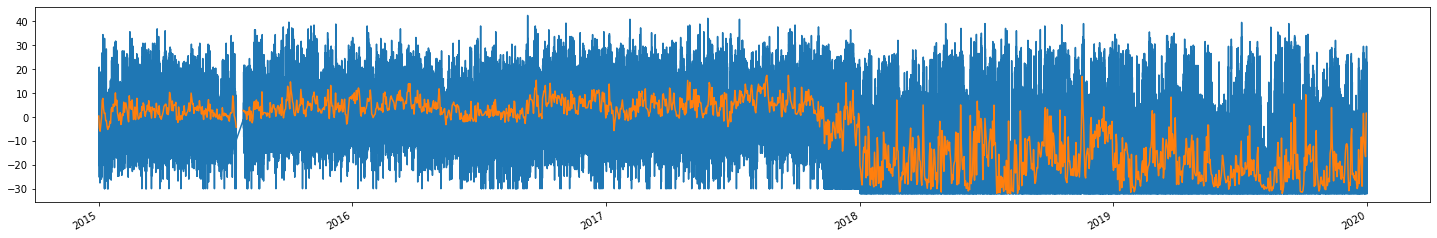

In [ ]:

plt.figure(figsize=(25,4))
df_radar_2_subset_dirty_interpolation.loc[:,'1475'].plot()
df_radar_2_subset_dirty_interpolation.loc[:,'1475'].resample('1d').mean().plot()

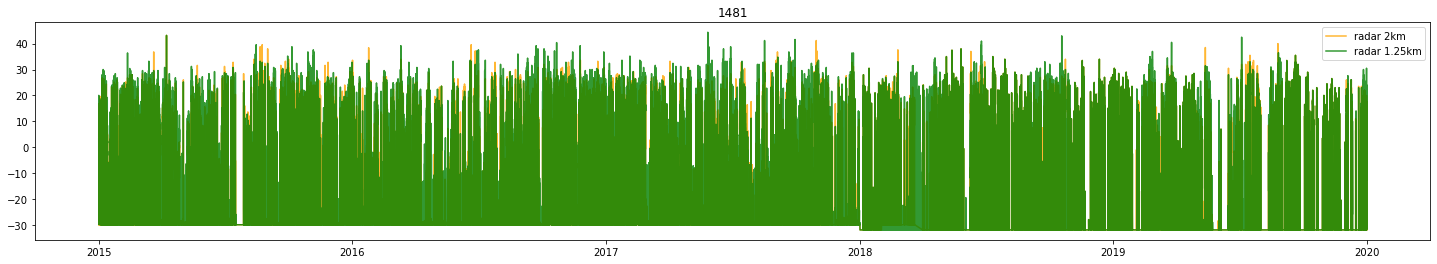

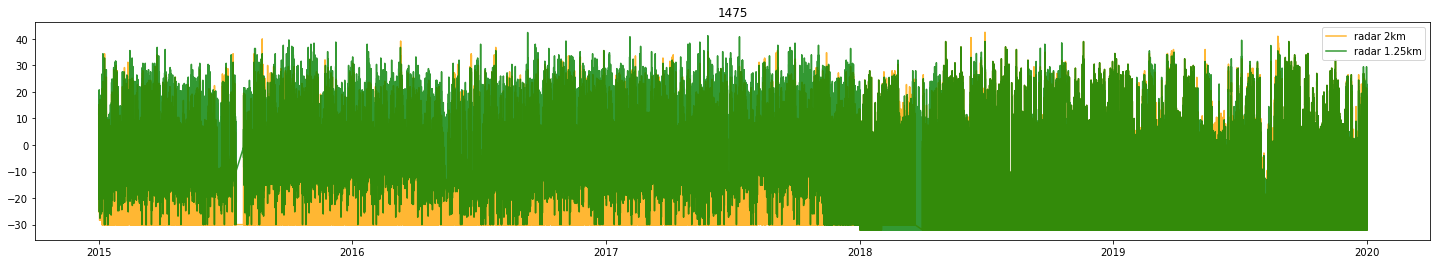

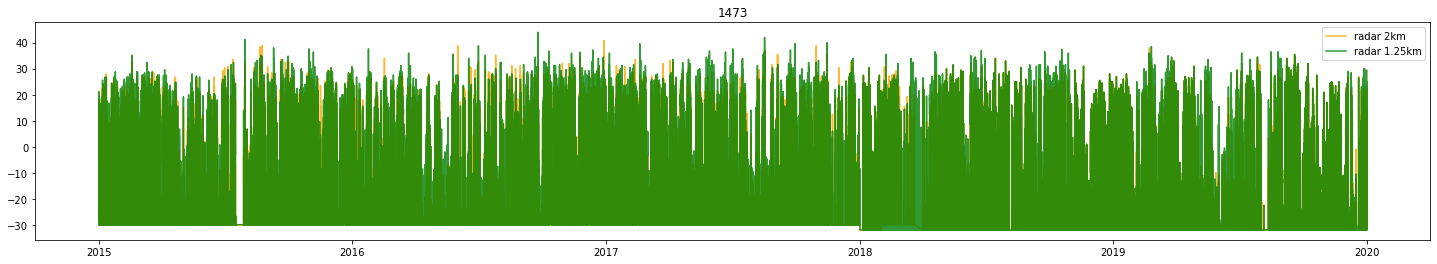

In [ ]:
# for col in df_radar_subset_dirty_interpolation.columns:
for col in df_radar_1_subset_dirty_interpolation.columns:
    available_gauges = [name for name in df_gauge.columns if col in name] 
    if len(available_gauges) == 0:
        continue
    if len(available_gauges) == 1:
        available_gauges = available_gauges[0]
    manual_gauge_idx = [i for i in available_gauges if 'manual' in i]
    # if len(manual_gauge_idx) == 0:
    #     selected_gauge = available_gauges[0]
    # else:
    #     selected_gauge = manual_gauge_idx[0]
    
    if len(df_gauge.loc[d_start:d_end,available_gauges].dropna()) == 0:
        continue
    
    plt.figure(figsize=(25,4))
    # h2 = plt.plot(df_radar_subset_dirty_interpolation.loc[d_start:d_end,col],color='orange',alpha = 0.5,label='radar')
    h2 = plt.plot(df_radar_1_subset_dirty_interpolation.loc[d_start:d_end,col].dropna(),color='orange',alpha = 0.8,label='radar 2km')
    h2 = plt.plot(df_radar_2_subset_dirty_interpolation.loc[d_start:d_end,col].dropna(),color='green',alpha = 0.8,label='radar 1.25km')
    # h1 = plt.twinx().plot(df_gauge.loc[d_start:d_end,available_gauges],label = available_gauges)
    plt.title(col)
    # available_gauges
    plt.legend()
    # plt.legend([h1[0],h2[0]], ['gauge','radar'])
    plt.show()
    

# Transformed values

In [ ]:
def to_rainfall(radar_data,a,b):
    rainfall = wrl.zr.z_to_r(wrl.trafo.idecibel(radar_data), a=a, b=b)
    return rainfall
# to_rainfall(-30.000,200,1.6)

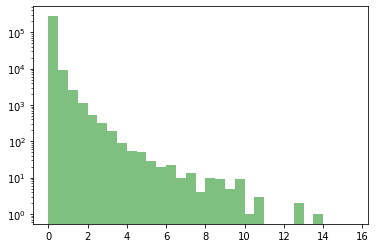

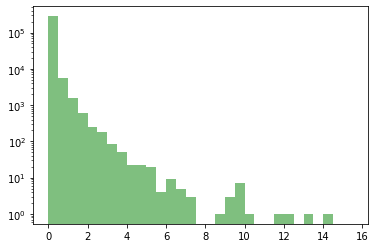

In [ ]:
plt.hist(to_rainfall(df_radar_2_subset_dirty_interpolation.loc[d_start:d_end,'1475'].dropna(),200,1.6),color='green',alpha = 0.5,label='radar2',bins=np.arange(0,16,0.5))
plt.yscale('log')
plt.show()

plt.hist(to_rainfall(df_radar_1_subset_dirty_interpolation.loc[d_start:d_end,'1475'].dropna(),200,1.6),color='green',alpha = 0.5,label='radar2',bins=np.arange(0,16,0.5))
plt.yscale('log')
plt.show()
# plt.plot(df_radar_2_subset_dirty_interpolation.loc[d_start:d_end,'1475'].dropna(),color='green',alpha = 0.5,label='radar2')

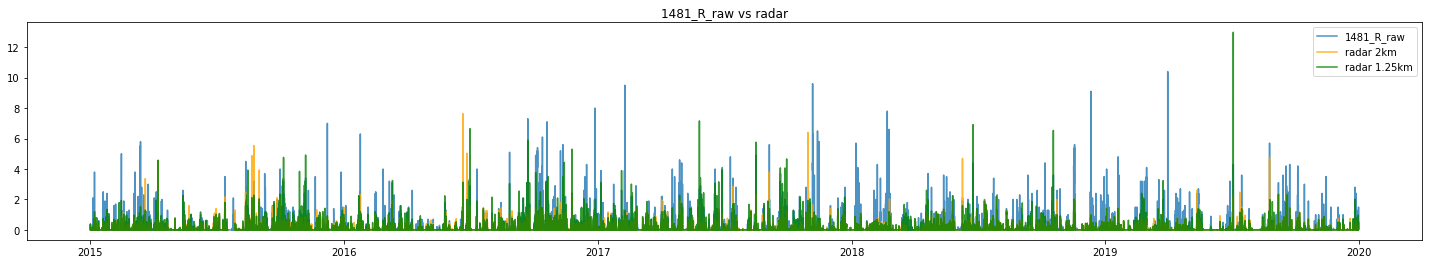

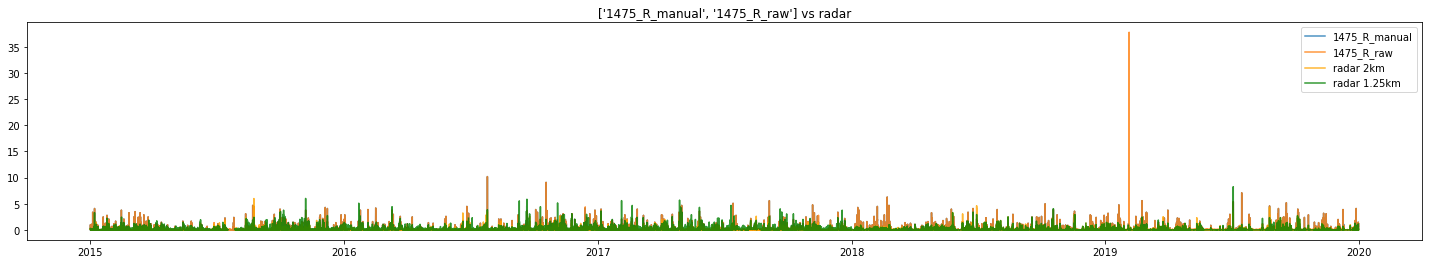

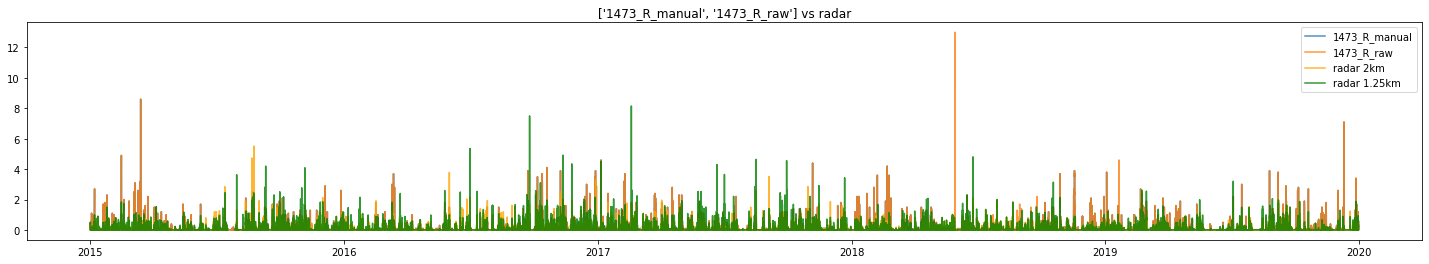

In [ ]:
# for col in df_radar_subset_dirty_interpolation.columns:
for col in df_radar_1_subset_dirty_interpolation.columns:
    available_gauges = [name for name in df_gauge.columns if col in name] 
    if len(available_gauges) == 0:
        continue
    if len(available_gauges) == 1:
        available_gauges = available_gauges[0]
    # manual_gauge_idx = [i for i in available_gauges if 'manual' in i]
        
    rain_gauge_values = df_gauge.loc[d_start:d_end,available_gauges]
    # echo_values = df_radar_subset_dirty_interpolation.loc[d_start:d_end,col]
    echo_values_1 = df_radar_1_subset_dirty_interpolation.loc[d_start:d_end,col]
    echo_values_2 = df_radar_2_subset_dirty_interpolation.loc[d_start:d_end,col]
    
    compute_rain = lambda x : to_rainfall(x,200,1.6)
    # rainfall_estimates = compute_rain(echo_values).resample('1h').mean()
    rainfall_estimates_1 = compute_rain(echo_values_1).resample('1h').mean()
    rainfall_estimates_2 = compute_rain(echo_values_2).resample('1h').mean()
    
    if len(rain_gauge_values.dropna()) == 0:
        continue
    
    plt.figure(figsize=(25,4))
    h1 = plt.plot(rain_gauge_values,label = available_gauges,alpha = 0.8)
    # h2 = plt.plot(rainfall_estimates,color='orange',alpha = 0.8,label='radar')
    h2 = plt.plot(rainfall_estimates_1,color='orange',alpha = 0.8,label='radar 2km')
    h3 = plt.plot(rainfall_estimates_2,color='green',alpha = 0.8,label = 'radar 1.25km')
    plt.title(str(available_gauges) + ' vs radar')
    plt.legend()
    # plt.legend([h1[0],h2[0],h3[0]], ['gauge','CAPPI at 2km','CAPPI at 1.25km'])
    plt.show()
    
    

# Cumulative rainfall

In [ ]:
# df_radar_subset_dirty_interpolation.columns

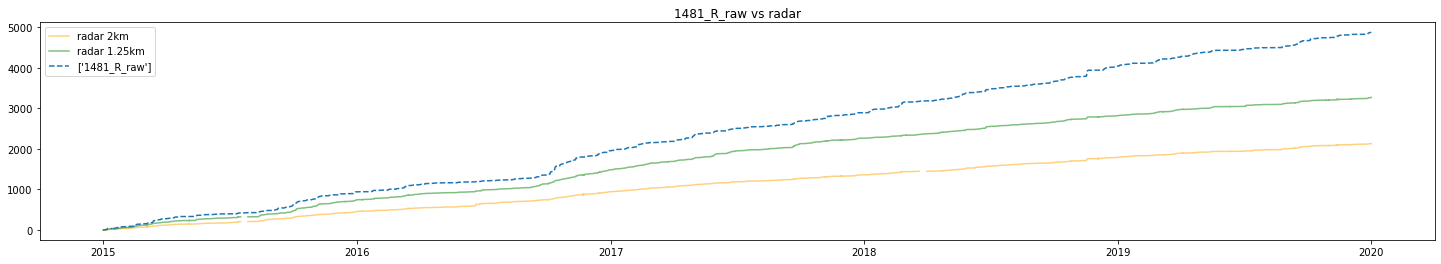

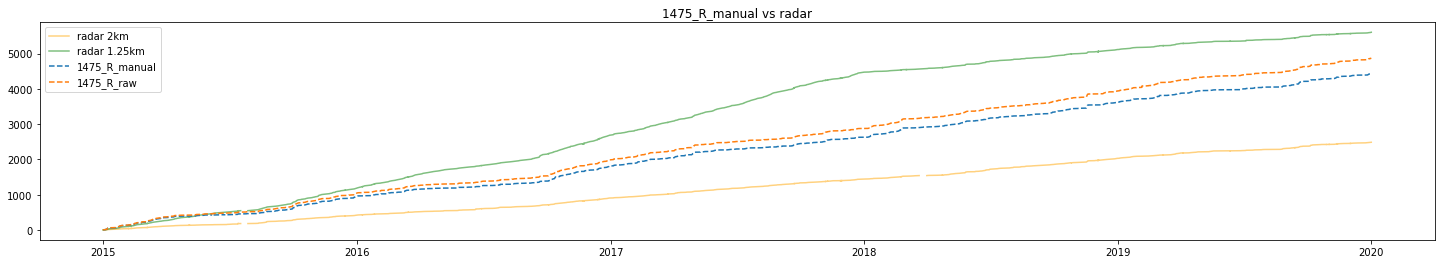

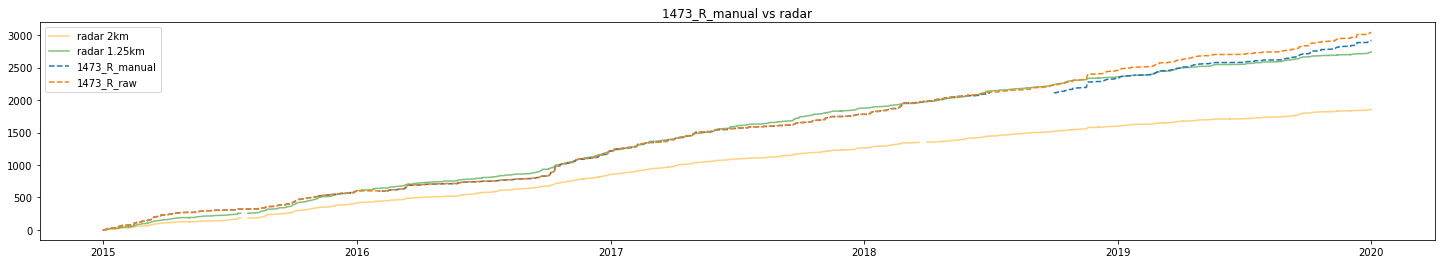

In [ ]:
# for col in df_radar_subset_dirty_interpolation.columns:
for col in df_radar_1_subset_dirty_interpolation.columns:
    available_gauges = [name for name in df_gauge.columns if col in name] 
    if len(available_gauges) == 0:
        continue
    
    manual_gauge_idx = [i for i in available_gauges if 'manual' in i]
    if len(manual_gauge_idx) == 0:
        selected_gauge = available_gauges[0]
    else:
        selected_gauge = manual_gauge_idx[0]
        
    rain_gauge_values = df_gauge.loc[d_start:d_end,available_gauges]
    # echo_values = df_radar_subset_dirty_interpolation.loc[d_start:d_end,col]
    echo_values_1 = df_radar_1_subset_dirty_interpolation.loc[d_start:d_end,col]
    echo_values_2 = df_radar_2_subset_dirty_interpolation.loc[d_start:d_end,col]
    
    compute_rain = lambda x : to_rainfall(x,200,1.6)
    # rainfall_estimates = compute_rain(echo_values)
    rainfall_estimates_1 = compute_rain(echo_values_1).resample('1h').mean()
    rainfall_estimates_2 = compute_rain(echo_values_2).resample('1h').mean()
    # rainfall_estimates_2[rainfall_estimates_2 < 0.1] = 0
    if len(rain_gauge_values.dropna()) == 0:
        continue
    
    # if col != '1481':
    #     continue
    plt.figure(figsize=(25,4))
    h2 = plt.plot(rainfall_estimates_1.resample('1h').mean().cumsum(),color='orange',alpha = 0.5,label='radar 2km')
    h2 = plt.plot(rainfall_estimates_2.resample('1h').mean().cumsum(),color='green',alpha = 0.5,label='radar 1.25km')
    h1 = plt.plot(rain_gauge_values.cumsum(),label = available_gauges,linestyle='--')
    
    plt.title(selected_gauge + ' vs radar')
    # plt.legend([h1[0],h2[0]], ['gauge','radar'])
    plt.legend()
    plt.show()
    

# Difference in estimates over whole month

In [ ]:
month_starts = []
month_ends = []
# for year in range(2015,2020):
#     for month in range(1,13):
#         month_starts.append(datetime.datetime(year,month,1))
#         if month != 12:
#             month_ends.append(datetime.datetime(year,month+1,1) - datetime.timedelta(days = 1))
#         else:
#             month_ends.append(datetime.datetime(year,month,31))
for year in range(2015,2019):
    for month in range(1,12):
        month_starts.append(datetime.datetime(year,month,1))
        if month != 12:
            month_ends.append(datetime.datetime(year,month+1,1) - datetime.timedelta(days = 1))
        else:
            month_ends.append(datetime.datetime(year,month,31))
    
    
# differences = []
# p_differences = []
differences_1 = []
differences_2 = []
total_differences_1 = []
total_differences_2 = []
for d_month_start,d_month_end in zip(month_starts,month_ends):
    # differences_sensors = {}
    # total_differences_sensors = {}
    differences_1_sensors = {}
    total_differences_1_sensors = {}
    differences_2_sensors = {}
    total_differences_2_sensors = {}
    # for col in df_radar_subset_dirty_interpolation.columns:
    for col in df_radar_1_subset_dirty_interpolation.columns:
        available_gauges = [name for name in df_gauge.columns if col in name] 
        # selected_gauge = available_gauges
        if len(available_gauges) == 0:
            continue
        
        manual_gauge_idx = [i for i in available_gauges if 'manual' in i]
        if len(manual_gauge_idx) == 0:
            selected_gauge = available_gauges[0]
        else:
            selected_gauge = manual_gauge_idx[0]
            
        rain_gauge_values = df_gauge.loc[d_month_start:d_month_end,selected_gauge]
        # echo_values = df_radar_subset_dirty_interpolation.loc[d_month_start:d_month_end,col]
        echo_values_1 = df_radar_1_subset_dirty_interpolation.loc[d_start:d_end,col]
        echo_values_2 = df_radar_2_subset_dirty_interpolation.loc[d_start:d_end,col]
        
        compute_rain = lambda x : to_rainfall(x,200,1.6)
        # rainfall_estimates = compute_rain(echo_values).resample('1h').mean()
        rainfall_estimates_1 = compute_rain(echo_values_1).resample('1h').mean()
        rainfall_estimates_2 = compute_rain(echo_values_2).resample('1h').mean()
        
        if len(rain_gauge_values.dropna()) == 0:
            continue
        
        # difference = rain_gauge_values - rainfall_estimates
        difference_1 = rain_gauge_values - rainfall_estimates_1
        difference_2 = rain_gauge_values - rainfall_estimates_2
        total_difference_1 = np.sum(difference_1)
        total_difference_2 = np.sum(difference_2)
        
        # differences_sensors[col] = difference
        differences_1_sensors[col] = difference_1
        differences_2_sensors[col] = difference_2
        # total_differences_sensors[col] = total_difference
        total_differences_1_sensors[col] = total_difference_1
        total_differences_2_sensors[col] = total_difference_2
    # differences.append(differences_sensors)
    differences_1.append(differences_1_sensors)
    differences_2.append(differences_2_sensors)
    # total_differences.append(total_differences_sensors)
    total_differences_1.append(total_differences_1_sensors)
    total_differences_2.append(total_differences_2_sensors)
    
# df_differences = pd.DataFrame(differences,index = month_starts)
df_differences_1 = pd.DataFrame(differences_1,index = month_starts)
df_differences_2 = pd.DataFrame(differences_2,index = month_starts)
# df_total_differences = pd.DataFrame(total_differences,index = month_starts)
df_total_differences_1 = pd.DataFrame(total_differences_1,index = month_starts)
df_total_differences_2 = pd.DataFrame(total_differences_2,index = month_starts)
# total_total_difference = df_total_differences.mean().mean()
total_total_difference_1 = df_total_differences_1.mean().mean()
total_total_difference_2 = df_total_differences_2.mean().mean()

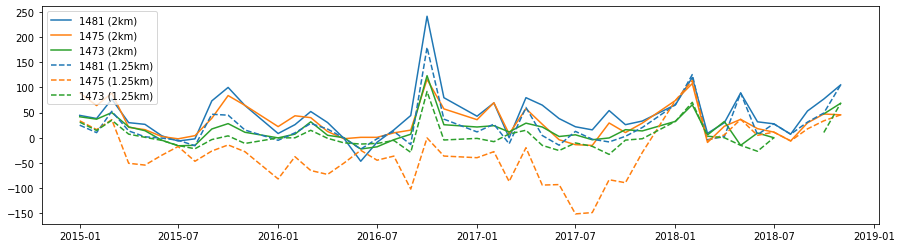

In [ ]:
# plt.plot(df_total_differences)
plt.figure(figsize=(15,4))
plt.plot(df_total_differences_1,label=[i+' (2km)' for i in df_total_differences_1.columns])
plt.gca().set_prop_cycle(None)
plt.plot(df_total_differences_2,linestyle='--',label=[i+' (1.25km)' for i in df_total_differences_2.columns])
# plt.legend(df_total_differences_1.columns)
plt.legend()
plt.show()

# static adjustment of minimum persentage difference

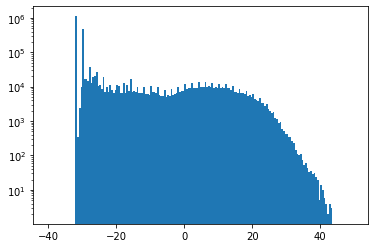

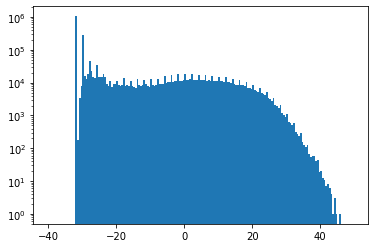

In [ ]:
# plt.hist(df_radar_subset_dirty_interpolation.values.ravel(),bins=np.arange(-40,50,0.5))
# plt.yscale('log')
# plt.show()

plt.hist(df_radar_1_subset_dirty_interpolation.values.ravel(),bins=np.arange(-40,50,0.5))
plt.yscale('log')
plt.show()

plt.hist(df_radar_2_subset_dirty_interpolation.values.ravel(),bins=np.arange(-40,50,0.5))
plt.yscale('log')
plt.show()

# plt.hist(to_rainfall(df_radar_subset_dirty_interpolation.values.ravel(),200,1.6),bins=np.arange(-40,50,0.5))
# plt.yscale('log')
# plt.show()

# plt.hist(to_rainfall(df_radar_subset_dirty_interpolation.values.ravel(),200,1.6),bins=np.arange(-40,50,0.5))
# plt.yscale('log')
# plt.show()


In [ ]:
# month_starts = []
# month_ends = []
# for year in range(2015,2020):
#     for month in range(1,13):
#         month_starts.append(datetime.datetime(year,month,1))
#         if month != 12:
#             month_ends.append(datetime.datetime(year,month+1,1) - datetime.timedelta(days = 1))
#         else:
#             month_ends.append(datetime.datetime(year,month,31))
    
warm_months = [4,5,6,7,8,9]
cold_months = [1,2,3,10,11,12]

def average_difference(ab,use_warm = True):
    a,b = ab
    differences = []
    p_differences = []
    
    # if use_warm:
    #     used_months = warm_months
    # else:
    #     used_months = cold_months
        
    for d_month_start,d_month_end in zip(month_starts,month_ends):

        # if d_month_start.month not in used_months:
        #     continue
        differences_sensors = {}
        p_differences_sensors = {}
        for col in df_radar_subset_dirty_interpolation.columns:
            available_gauges = [name for name in df_gauge.columns if col in name] 
            if len(available_gauges) == 0:
                continue
            
            
            manual_gauge_idx = [i for i in available_gauges if 'manual' in i]
            if len(manual_gauge_idx) == 0:
                selected_gauge = available_gauges[0]
            else:
                selected_gauge = manual_gauge_idx[0]
                
            rain_gauge_values = df_gauge.loc[d_month_start:d_month_end,selected_gauge]
            echo_values = df_radar_subset_dirty_interpolation.loc[d_month_start:d_month_end,col]
            
            compute_rain = lambda x : to_rainfall(x,a,b)
            rainfall_estimates = compute_rain(echo_values).resample('1h').mean()
            rainfall_estimates[rainfall_estimates < 0.01] = 0
            # if len(rain_gauge_values.dropna()) == 0:
            #     continue
                        
            if rain_gauge_values.isna().sum() > 0:
                continue
            
            if rainfall_estimates.isna().sum() > 0:
                continue
        
            
            difference = rain_gauge_values - rainfall_estimates
            p_difference = np.abs(np.sum(difference))
            
            differences_sensors[col] = difference
            p_differences_sensors[col] = p_difference
        differences.append(differences_sensors)
        p_differences.append(p_differences_sensors)
        
    df_differences = pd.DataFrame(differences,index = [m for m in month_starts])
    df_p_differences = pd.DataFrame(p_differences,index = [m for m in month_starts])
    total_p_difference = df_p_differences.mean().mean()
    print(total_p_difference)
    return total_p_difference

In [ ]:
from scipy.optimize import minimize

df_radar_subset_dirty_interpolation = df_radar_2_subset_dirty_interpolation
# df_radar_subset_dirty_interpolation = df_radar_1_subset_dirty_interpolation
# results = minimize(average_difference, (200,1.6),tol = 1e-2, )
# a,b = results.x
a,b = (200,1.6)

# Instantaneous differences across months


In [ ]:
# month_starts = []
# month_ends = []
# for year in range(2015,2020):
#     for month in range(1,13):
#         month_starts.append(datetime.datetime(year,month,1))
#         if month != 12:
#             month_ends.append(datetime.datetime(year,month+1,1) - datetime.timedelta(days = 1))
#         else:
#             month_ends.append(datetime.datetime(year,month,31))
    
def squared_difference(ab):
    a,b = ab
    differences = []
    p_differences = []
    
    for d_month_start,d_month_end in zip(month_starts,month_ends):

        differences_sensors = {}
        p_differences_sensors = {}
        for col in df_radar_subset_dirty_interpolation.columns:
            available_gauges = [name for name in df_gauge.columns if col in name] 
            if len(available_gauges) == 0:
                continue
            
            
            manual_gauge_idx = [i for i in available_gauges if 'manual' in i]
            if len(manual_gauge_idx) == 0:
                selected_gauge = available_gauges[0]
            else:
                selected_gauge = manual_gauge_idx[0]
                
            rain_gauge_values = df_gauge.loc[d_month_start:d_month_end,selected_gauge]
            echo_values = df_radar_subset_dirty_interpolation.loc[d_month_start:d_month_end,col]
            
            compute_rain = lambda x : to_rainfall(x,a,b)
            rainfall_estimates = compute_rain(echo_values)
            
            # if len(rain_gauge_values.dropna()) == 0:
            #     continue
                        
            # if rain_gauge_values.isna().sum() > 0:
            #     continue
            
            # if rainfall_estimates.isna().sum() > 0:
            #     continue
            
            difference = rain_gauge_values - rainfall_estimates.resample('1h').mean()
            
            p_difference = np.sum(difference**2)
            
            differences_sensors[col] = difference
            p_differences_sensors[col] = p_difference
        differences.append(differences_sensors)
        p_differences.append(p_differences_sensors)
        
    df_differences = pd.DataFrame(differences,index = [m for m in month_starts])
    df_p_differences = pd.DataFrame(p_differences,index = [m for m in month_starts])
    
    # print(df_p_differences)
    total_p_difference = df_p_differences.mean().mean()
    print(total_p_difference)
    return total_p_difference

In [ ]:
squared_difference((200,1.6))

126.69591934608029


126.69591934608029

In [ ]:
# results_lstq = minimize(squared_difference, (200,1.6),tol = 1e-2)

126.69591934608029
126.69591934608029
126.69591934667991
126.69591920622202
119.75397383518478
119.75397383518478
119.75397383565618
119.75397376248353
116.27710249616993
116.27710249616993
116.2771024964608
116.27710247198185
115.76308541009014
115.76308541009014
115.76308541029529
115.76308540576166
115.74427480825425
115.74427480825425
115.74427480844123
115.7442748079127
115.74397959509533
115.74397959509533
115.74397959528063
115.7439795951177
115.74368833785903
115.74368833785903
115.7436883380434
115.74368833809673
115.74314841679298
115.74314841679298
115.74314841697642
115.74314841724842
115.742128803874
115.742128803874
115.7421288040563
115.74212880459312
115.74019891502535
115.74019891502535
115.74019891520622
115.74019891610222
115.73657250833328
115.73657250833328
115.7365725085122
115.73657250992991
115.72986428776254
115.72986428776254
115.72986428793865
115.72986429014536
115.71776085163656
115.71776085163656
115.7177608518086
115.7177608552315
115.6966519818699
115.69

In [ ]:
results_lstq

      fun: 111.51625372971007
 hess_inv: array([[118.823934  ,   0.95942104],
       [  0.95942104,   0.25565523]])
      jac: array([ 0.00021553, -0.00251198])
  message: 'Optimization terminated successfully.'
     nfev: 112
      nit: 26
     njev: 28
   status: 0
  success: True
        x: array([33.75857218,  2.86072027])

<AxesSubplot:>

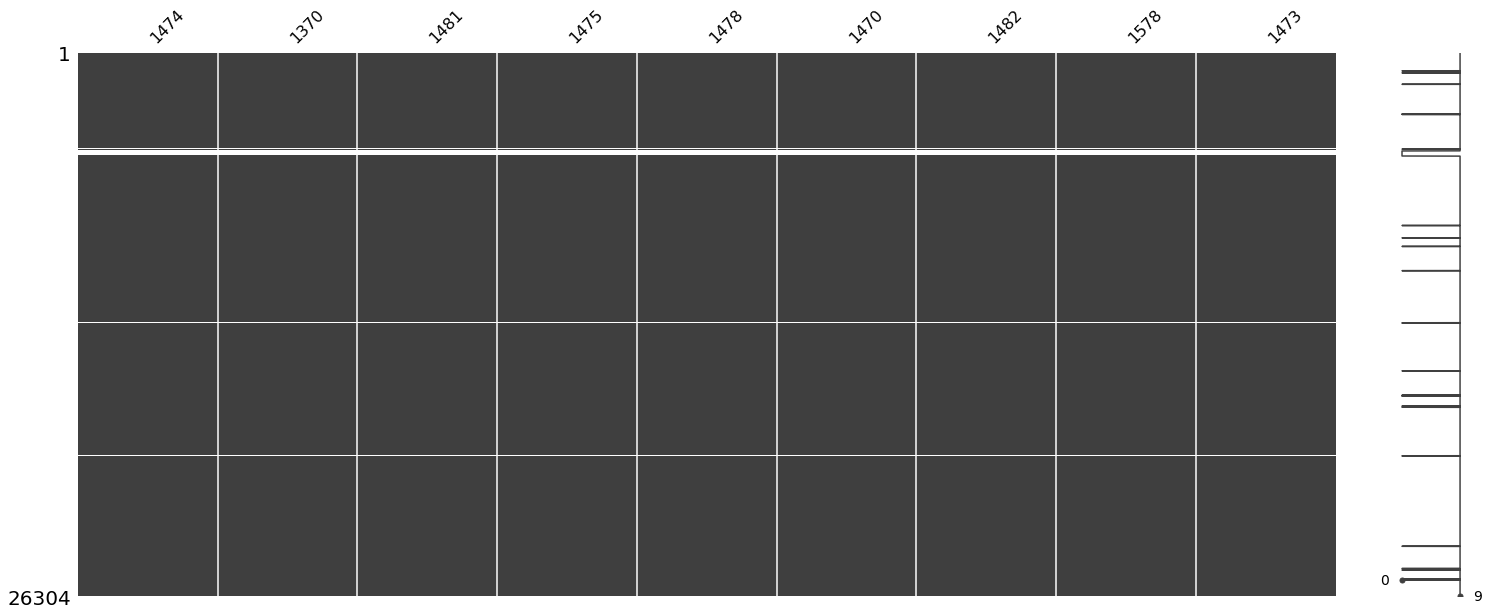

In [ ]:
matrix(compute_rain(df_radar_subset_dirty_interpolation).resample('1h').mean())

In [ ]:
# compute_rain(df_radar_subset_dirty_interpolation).resample('1h').mean()

# Testing out the results

In [ ]:
# month_starts = []
# month_ends = []
# for year in range(2015,2020):
#     for month in range(1,13):
#         month_starts.append(datetime.datetime(year,month,1))
#         if month != 12:
#             month_ends.append(datetime.datetime(year,month+1,1) - datetime.timedelta(days = 1))
#         else:
#             month_ends.append(datetime.datetime(year,month,31))

df_radar_subset_dirty_interpolation = df_radar_2_subset_dirty_interpolation

# differences = []
differences_1 = []
differences_2 = []
# p_differences = []
p_differences_1 = []
p_differences_2 = []
for d_month_start,d_month_end in zip(month_starts,month_ends):
    # differences_sensors = {}
    differences_sensors_1 = {}
    differences_sensors_2 = {}
    # p_differences_sensors = {}
    p_differences_sensors_1 = {}
    p_differences_sensors_2 = {}
    for col in df_radar_subset_dirty_interpolation.columns:
        available_gauges = [name for name in df_gauge.columns if col in name] 
        if len(available_gauges) == 0:
            continue
        
        manual_gauge_idx = [i for i in available_gauges if 'manual' in i]
        if len(manual_gauge_idx) == 0:
            selected_gauge = available_gauges[0]
        else:
            selected_gauge = manual_gauge_idx[0]
            
        rain_gauge_values = df_gauge.loc[d_month_start:d_month_end,selected_gauge]
        # echo_values = df_radar_subset_dirty_interpolation.loc[d_month_start:d_month_end,col]
        echo_values_1 = df_radar_1_subset_dirty_interpolation.loc[d_month_start:d_month_end,col]
        echo_values_2 = df_radar_2_subset_dirty_interpolation.loc[d_month_start:d_month_end,col]
        
        compute_rain = lambda x : to_rainfall(x,200,1.6)
        # rainfall_estimates = compute_rain(echo_values).resample('1h').mean()
        rainfall_estimates_1 = compute_rain(echo_values_1).resample('1h').mean()
        rainfall_estimates_2 = compute_rain(echo_values_2).resample('1h').mean()
        
        if len(rain_gauge_values.dropna()) == 0:
            continue
        
        if rain_gauge_values.isna().mean() > 0.5:
            continue
        # print(rainfall_estimates.isna().sum(),rain_gauge_values.isna().mean())
        if rainfall_estimates_1.isna().mean() > 0.5:
            continue
        if rainfall_estimates_2.isna().mean() > 0.5:
            continue
        
        
        # difference = rain_gauge_values.cumsum().iloc[-1] - rainfall_estimates.cumsum().iloc[-1]
        difference_1 = rain_gauge_values.cumsum().iloc[-1] - rainfall_estimates_1.cumsum().iloc[-1]
        difference_2 = rain_gauge_values.cumsum().iloc[-1] - rainfall_estimates_2.cumsum().iloc[-1]
        
        # p_difference = np.abs(difference) / rain_gauge_values.cumsum().iloc[-1]
        p_difference_1 = np.abs(difference_1) / rain_gauge_values.cumsum().iloc[-1]
        p_difference_2 = np.abs(difference_2) / rain_gauge_values.cumsum().iloc[-1]
        # print(col,d_month_start,p_difference)
        # differences_sensors_1[col] = difference
        differences_sensors_1[col] = difference_1
        differences_sensors_2[col] = difference_2
        # p_differences_sensors_2[col] = p_difference
        p_differences_sensors_1[col] = p_difference_1
        p_differences_sensors_2[col] = p_difference_2
        
    # differences.append(differences_sensors)
    differences_1.append(differences_sensors_1)
    differences_2.append(differences_sensors_2)
    # p_differences.append(p_differences_sensors)
    p_differences_1.append(p_differences_sensors_1)
    p_differences_2.append(p_differences_sensors_2)
    
# df_differences = pd.DataFrame(differences,index = month_starts)
df_differences_1 = pd.DataFrame(differences_1,index = month_starts)
df_differences_2 = pd.DataFrame(differences_2,index = month_starts)
# df_p_differences = pd.DataFrame(p_differences,index = month_starts)
df_p_differences_1 = pd.DataFrame(p_differences_1,index = month_starts)
df_p_differences_2 = pd.DataFrame(p_differences_2,index = month_starts)
# total_p_difference = df_p_differences.mean().mean()


In [ ]:
rainfall_estimates_1

Series([], Freq: H, Name: 1481, dtype: float64)

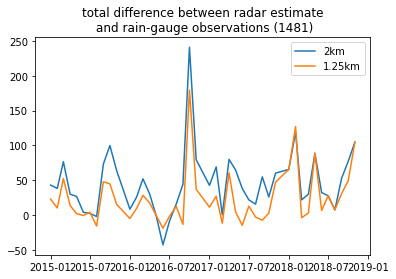

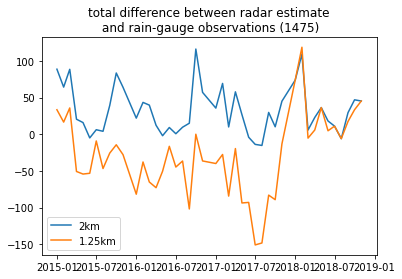

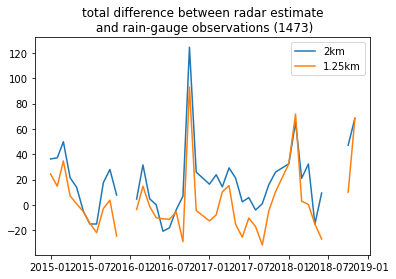

In [ ]:
for col in df_differences_1.columns:
    plt.plot(df_differences_1.loc[:,col])
    plt.plot(df_differences_2.loc[:,col])
    plt.title('total difference between radar estimate\n and rain-gauge observations ('+col+')')
    plt.legend(['2km','1.25km'])
    plt.show()

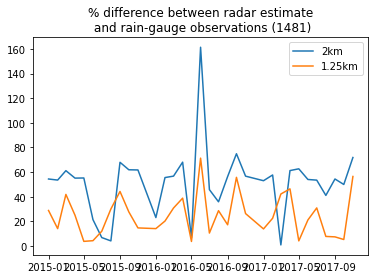

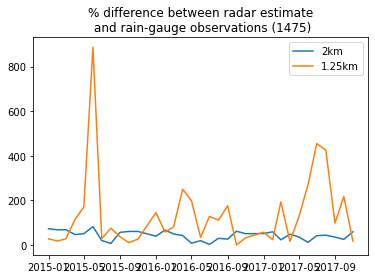

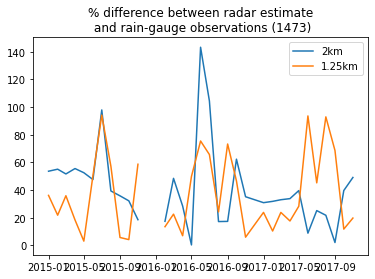

In [ ]:
for col in df_p_differences_1.columns:
    plt.plot(df_p_differences_1.loc[:,col]*100)
    plt.plot(df_p_differences_2.loc[:,col]*100)
    plt.title('% difference between radar estimate\n and rain-gauge observations ('+col+')')
    plt.legend(['2km','1.25km'])
    plt.show()

In [ ]:

# plt.plot(df_p_differences)
plt.plot(df_p_differences_1)
plt.gca().set_prop_cycle(None)
plt.plot(df_p_differences_2,linestyle='--')
plt.legend(df_p_differences_1.columns)
plt.title('difference between the cumulative rainfall at the end of the month')
# plt.yscale('log')
plt.show()

In [ ]:
df_p_differences.corr()

,1481,1475,1473,1482,1474
1481,1.000000,0.521413,0.535242,0.762742,0.865399
1475,0.521413,1.000000,0.505770,0.628663,0.698963
1473,0.535242,0.505770,1.000000,0.906311,0.976629
1482,0.762742,0.628663,0.906311,1.000000,0.848665
1474,0.865399,0.698963,0.976629,0.848665,1.000000


In [ ]:
df_p_differences.idxmax()

1481   2016-10-01
1475   2015-06-01
1473   2019-06-01
1482   2019-09-01
1474   2019-06-01
dtype: datetime64[ns]

In [ ]:
index_to_view = 30
d_month_start,d_month_end = month_starts[index_to_view],month_ends[index_to_view]

In [ ]:
df_radar_subset_dirty_interpolation = df_radar_1_subset_dirty_interpolation

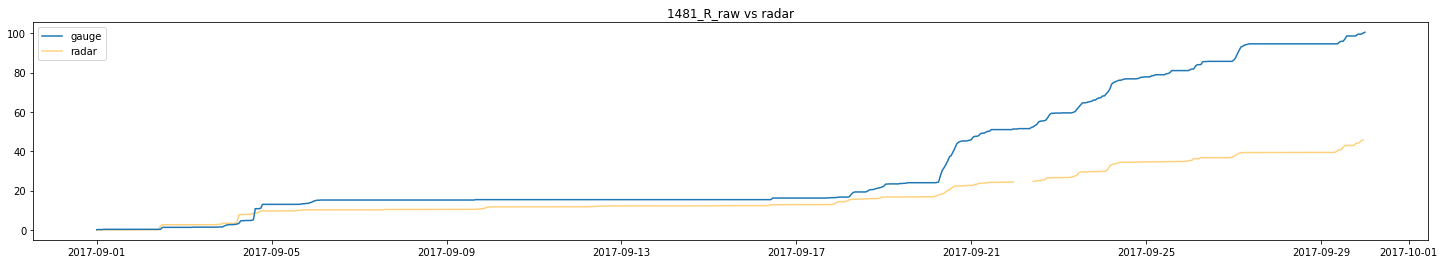

82.64032415323933


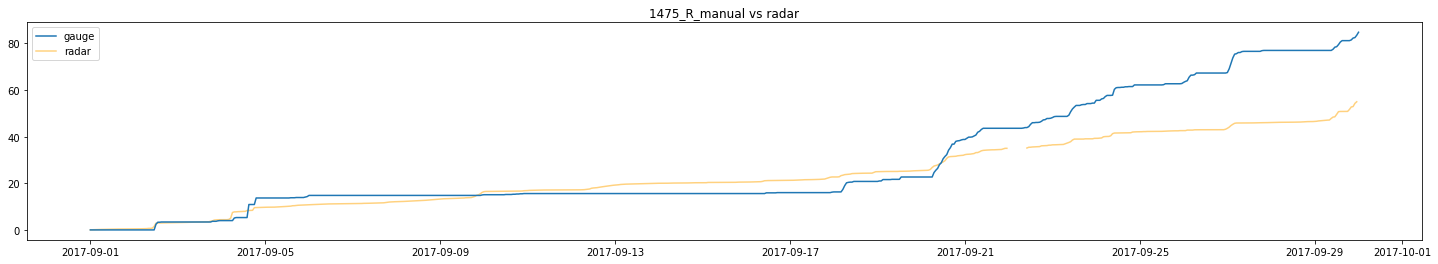

135.09988471056943


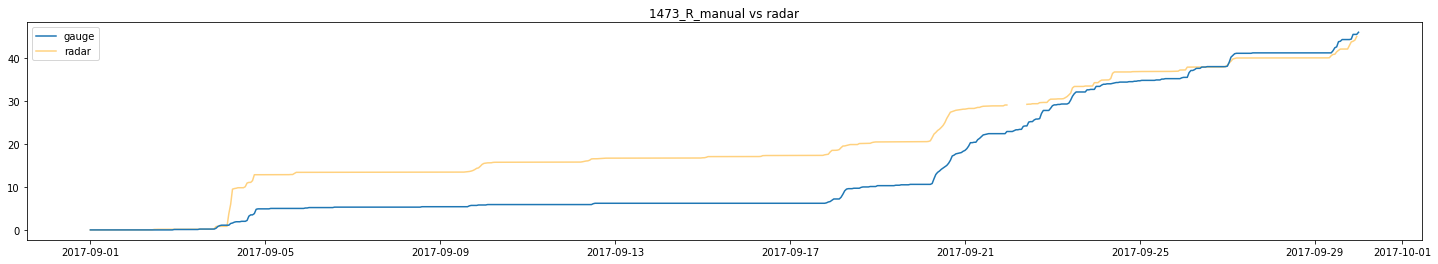

134.0438672873384


In [ ]:
for col in df_radar_subset_dirty_interpolation.columns:
    available_gauges = [name for name in df_gauge.columns if col in name] 
    if len(available_gauges) == 0:
        continue
    
    manual_gauge_idx = [i for i in available_gauges if 'manual' in i]
    if len(manual_gauge_idx) == 0:
        selected_gauge = available_gauges[0]
    else:
        selected_gauge = manual_gauge_idx[0]
        
    rain_gauge_values = df_gauge.loc[d_month_start:d_month_end,selected_gauge]
    echo_values = df_radar_subset_dirty_interpolation.loc[d_month_start:d_month_end,col]
    
    compute_rain = lambda x : to_rainfall(x,a,b)
    rainfall_estimates = compute_rain(echo_values)
    
    if len(rain_gauge_values.dropna()) == 0:
        continue
    
    difference = rain_gauge_values.cumsum().iloc[-1] - rainfall_estimates.cumsum().iloc[-1]
    p_difference = np.abs(difference)
    
    
    plt.figure(figsize=(25,4))
    h2 = plt.plot(rainfall_estimates.resample('1h').mean().cumsum(),color='orange',alpha = 0.5,label='radar')
    h1 = plt.plot(rain_gauge_values.cumsum(),label = selected_gauge)
    plt.title(selected_gauge + ' vs radar')
    plt.legend([h1[0],h2[0]], ['gauge','radar'])
    plt.show()
    print(p_difference)

# Visualize subset of data used for Gelgjutangi

In [ ]:
df_meta_gauge

,Nafn,gerð,nr,nr2,nafn_stutt,svæði,GPS,hæð,ár,Eign,x,y
0,Fíflholt á Mýrum,Sjálfvirk veðurathugunarstöð,1868,4914,fiflh,Faxaflói(fa),"64°41.659', 22°08.840' (64,6943, 22,1473)",40.0 m.y.s.,2006,Veðurstofa Íslands,64.6943,22.1473
1,Garðabær - Urriðaholt,Sjálfvirk veðurathugunarstöð,1474,-99,uholt,Faxaflói(fa),"64°4.270, 21°54.640 (64,0712, 21,9107)",37.0 m.y.s.,2019,Veðurstofa Íslands,64.0712,21.9107
2,Hellisskarð,Sjálfvirk veðurathugunarstöð,1490,4862,hells,Faxaflói(fa),"64°02.000', 21°21.992' (64,0333, 21,3665)",380.0 m.y.s.,2001,Veðurstofa Íslands,64.0333,21.3665
3,Hvanneyri,Sjálfvirk veðurathugunarstöð,1779,4134,hveyr,Faxaflói(fa),"64°33,732', 21°45,896' (64,5622, 21,7649)",12.399999618530273 m.y.s.,1997,Veðurstofa Íslands,64.5622,21.7649
4,Hvassahraun,Sjálfvirk veðurathugunarstöð,1370,4824,hvass,Faxaflói(fa),"64°01.181', 22°05.513' (64,0197, 22,0919)",41.0 m.y.s.,2001,Veðurstofa Íslands,64.0197,22.0919
5,Hólmsheiði,Sjálfvirk veðurathugunarstöð,1481,4920,holms,Faxaflói(fa),"64°06.510', 21°41.182' (64,1085, 21,6864)",130.0 m.y.s.,2006,Veðurstofa Íslands,64.1085,21.6864
6,Reykjavík búveðurstöð,Sjálfvirk veðurathugunarstöð,1475,4930,reits,Faxaflói(fa),"64°07.646', 21°54.146' (64,1274, 21,9024)",52.0 m.y.s.,2000,Veðurstofa Íslands,64.1274,21.9024
7,Reykjavík Geirsnef,Sjálfvirk veðurathugunarstöð,1478,-99,genef,Faxaflói(fa),"64°07.755', 21°50.351' (64,1292, 21,8392)",4.0 m.y.s.,2019,Veðurstofa Íslands,64.1292,21.8392
8,Reykjavík Háahlíð,Sjálfvirk veðurathugunarstöð,1470,-99,reith,Faxaflói(fa),"64°07.730', 21°54.493' (64,1288, 21,9082)",60.20000076293945 m.y.s.,2021,Veðurstofa Íslands,64.1288,21.9082
9,Reykjavík Víðidalur,Sjálfvirk veðurathugunarstöð,1482,-99,vidal,Faxaflói(fa),"64°06.208, 21°47.825 (64,1035, 21,7971)",71.0 m.y.s.,2018,Veðurstofa Íslands,64.1035,21.7971


In [ ]:
GEL_gauge_x,GEL_gauge_y = transformer_gps_isl.transform(64.1292,-21.8392)
GEL_gauge_idx,GEL_gauge_idy = get_idx_from_coords(coords,GEL_gauge_x,GEL_gauge_y)

In [ ]:
CAPPI_indexes.shape,GEL_gauge_idx,GEL_gauge_idy

((602, 602), 312, 347)

In [ ]:
GEL_gauge_idx-gel_margin,GEL_gauge_idx+gel_margin,GEL_gauge_idy-gel_margin,GEL_gauge_idy+gel_margin

(309, 315, 344, 350)

In [ ]:
coords

array([[ 72330.81291684, 146416.97640427,   2000.        ],
       [ 73163.81291684, 146416.97640427,   2000.        ],
       [ 73996.81291684, 146416.97640427,   2000.        ],
       ...,
       [571297.81291684, 647049.97640427,   2000.        ],
       [572130.81291684, 647049.97640427,   2000.        ],
       [572963.81291684, 647049.97640427,   2000.        ]])

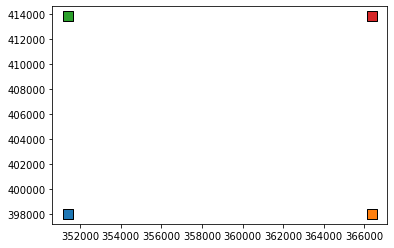

In [ ]:
# plt.scatter(coords[:,0],coords[:,1],s = 100,marker = 's',edgecolors='black')
# plt.scatter(coords[1,0],coords[1,1],s = 100,marker = 's',edgecolors='black')
# plt.scatter(coords[100,0],coords[100,1],s = 100,marker = 's',edgecolors='black')

cappi_idx = CAPPI_indexes[main_gauge_idx-margin:main_gauge_idx+margin,main_gauge_idy-margin:main_gauge_idy+margin].ravel()
pixels_handle = plt.scatter(coords[cappi_idx[1],0],coords[cappi_idx[1],1],s = 100,marker = 's',edgecolors='black')
pixels_handle = plt.scatter(coords[cappi_idx[19],0],coords[cappi_idx[19],1],s = 100,marker = 's',edgecolors='black')
pixels_handle = plt.scatter(coords[cappi_idx[381],0],coords[cappi_idx[381],1],s = 100,marker = 's',edgecolors='black')
pixels_handle = plt.scatter(coords[cappi_idx[399],0],coords[cappi_idx[399],1],s = 100,marker = 's',edgecolors='black')

In [ ]:
len(cappi_idx)

400

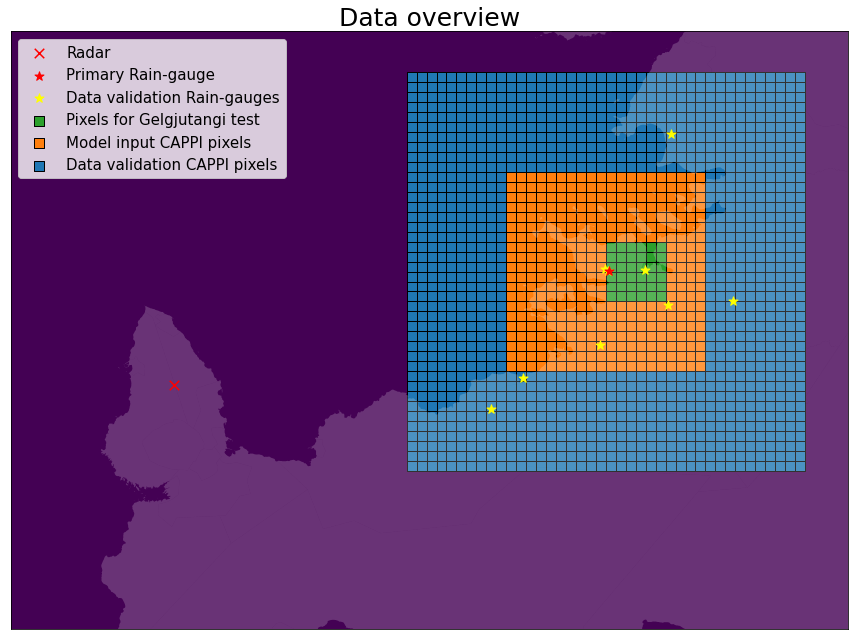

In [ ]:
margin_extra = 20
margin = 10
# margin = 30
gel_margin = 3

CAPPI_indexes = np.arange(602**2).reshape(602,602)

cappi_idx_extra = CAPPI_indexes[main_gauge_idx-margin_extra:main_gauge_idx+margin_extra,main_gauge_idy-margin_extra:main_gauge_idy+margin_extra].ravel()
cappi_idx = CAPPI_indexes[main_gauge_idx-margin:main_gauge_idx+margin,main_gauge_idy-margin:main_gauge_idy+margin].ravel()
cappi_idx_GEL = CAPPI_indexes[GEL_gauge_idx-gel_margin:GEL_gauge_idx+gel_margin,GEL_gauge_idy-gel_margin:GEL_gauge_idy+gel_margin].ravel()

plt.figure(figsize=(15,15))
pixels_handle_extra = plt.scatter(coords[cappi_idx_extra,0],coords[cappi_idx_extra,1],s = 100,marker = 's',edgecolors='black')
pixels_handle = plt.scatter(coords[cappi_idx,0],coords[cappi_idx,1],s = 100,marker = 's',edgecolors='black')
pixels_handle_GEL = plt.scatter(coords[cappi_idx_GEL,0],coords[cappi_idx_GEL,1],s = 100,marker = 's',edgecolors='black')

postnr.geometry.plot(ax = plt.gca(),alpha = 0.2,color='white')

radar_handle = plt.scatter(radar_x,radar_y,c ='red',marker = 'x',s = 90)

pixel_idx = []
for index,row in df_meta_gauge.iterrows():
    gauge_x,gauge_y = transformer_gps_isl.transform(row['x'],-row['y'])
    gauge_handle_extra = plt.scatter(gauge_x,gauge_y,c ='yellow',marker = '*',s = 90)
    gauge_idx,gauge_idy = get_idx_from_coords(coords,gauge_x,gauge_y)
    pixel_idx.append((gauge_idx,gauge_idy))
    
    
gauge_handle = plt.scatter(main_gauge_x,main_gauge_y,c ='red',marker = '*',s = 90)
plt.ylim(main_gauge_y - 30_000,main_gauge_y + 20_000)
plt.xlim(main_gauge_x - 50_000,main_gauge_x + 20_000)
plt.xticks([],[])
plt.yticks([],[])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
plt.title('Data overview',fontsize=25)
plt.legend([radar_handle,gauge_handle,gauge_handle_extra,pixels_handle_GEL,pixels_handle,pixels_handle_extra],['Radar','Primary Rain-gauge','Data validation Rain-gauges', 'Pixels for Gelgjutangi test','Model input CAPPI pixels','Data validation CAPPI pixels'],loc = 'upper left',fontsize=15)
plt.show()

In [ ]:
mean_echo_value_2km = df_radar_1.mean(axis=0).values
mean_echo_value_1_25km = df_radar_2.mean(axis=0).values

Text(0.5, 1.0, 'Sorted list of mean pixel values')

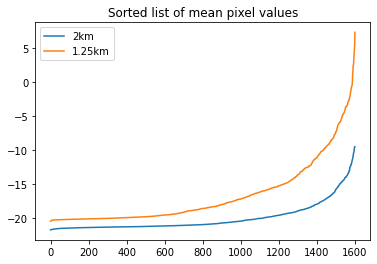

In [ ]:
plt.plot(sorted(mean_echo_value_2km),label = '2km')
plt.plot(sorted(mean_echo_value_1_25km),label = '1.25km')
plt.legend()
plt.title('Sorted list of mean pixel values')

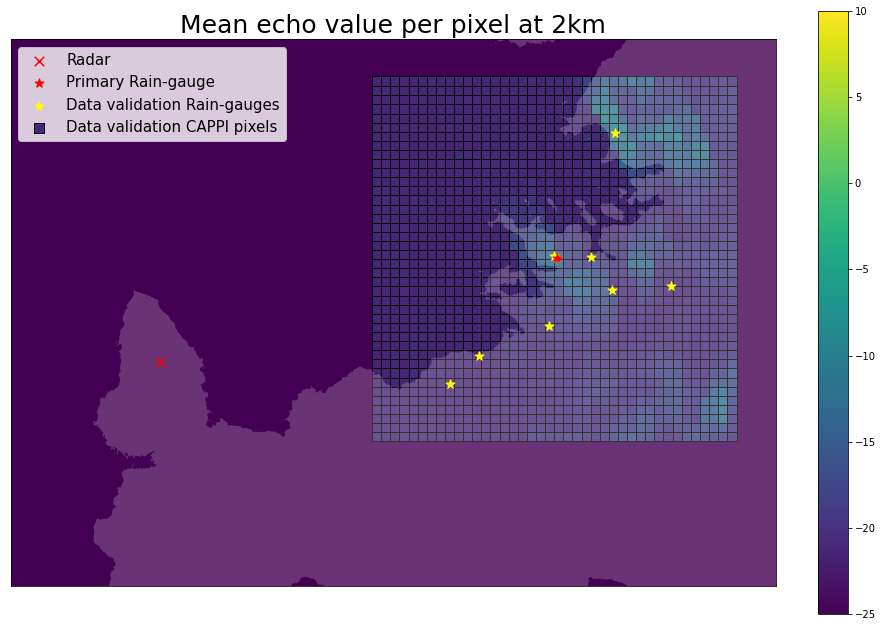

In [ ]:
margin_extra = 20
margin = 10
# margin = 30
gel_margin = 3

CAPPI_indexes = np.arange(602**2).reshape(602,602)

cappi_idx_extra = CAPPI_indexes[main_gauge_idx-margin_extra:main_gauge_idx+margin_extra,main_gauge_idy-margin_extra:main_gauge_idy+margin_extra].ravel()
cappi_idx = CAPPI_indexes[main_gauge_idx-margin:main_gauge_idx+margin,main_gauge_idy-margin:main_gauge_idy+margin].ravel()
cappi_idx_GEL = CAPPI_indexes[GEL_gauge_idx-gel_margin:GEL_gauge_idx+gel_margin,GEL_gauge_idy-gel_margin:GEL_gauge_idy+gel_margin].ravel()

plt.figure(figsize=(15,15))
pixels_handle_extra = plt.scatter(coords[cappi_idx_extra,0],coords[cappi_idx_extra,1],s = 100,marker = 's',edgecolors='black', c = mean_echo_value_2km,vmin = -25,vmax = 10)
plt.colorbar(fraction=0.036)
# pixels_handle = plt.scatter(coords[cappi_idx,0],coords[cappi_idx,1],s = 100,marker = 's',edgecolors='black')
# pixels_handle_GEL = plt.scatter(coords[cappi_idx_GEL,0],coords[cappi_idx_GEL,1],s = 100,marker = 's',edgecolors='black')

postnr.geometry.plot(ax = plt.gca(),alpha = 0.2,color='white')

radar_handle = plt.scatter(radar_x,radar_y,c ='red',marker = 'x',s = 90)

pixel_idx = []
for index,row in df_meta_gauge.iterrows():
    gauge_x,gauge_y = transformer_gps_isl.transform(row['x'],-row['y'])
    gauge_handle_extra = plt.scatter(gauge_x,gauge_y,c ='yellow',marker = '*',s = 90)
    gauge_idx,gauge_idy = get_idx_from_coords(coords,gauge_x,gauge_y)
    pixel_idx.append((gauge_idx,gauge_idy))
    
    
gauge_handle = plt.scatter(main_gauge_x,main_gauge_y,c ='red',marker = '*',s = 90)
plt.ylim(main_gauge_y - 30_000,main_gauge_y + 20_000)
plt.xlim(main_gauge_x - 50_000,main_gauge_x + 20_000)
plt.xticks([],[])
plt.yticks([],[])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
plt.title('Mean echo value per pixel at 2km',fontsize=25)
plt.legend(
    [
        radar_handle,
        gauge_handle,
        gauge_handle_extra,
        # pixels_handle_GEL,
        # pixels_handle,
        pixels_handle_extra,
    ],
    [
        "Radar",
        "Primary Rain-gauge",
        "Data validation Rain-gauges",
        # "Pixels for Gelgjutangi test",
        # "Model input CAPPI pixels",
        "Data validation CAPPI pixels",
    ],
    loc="upper left",
    fontsize=15,
)
plt.show()

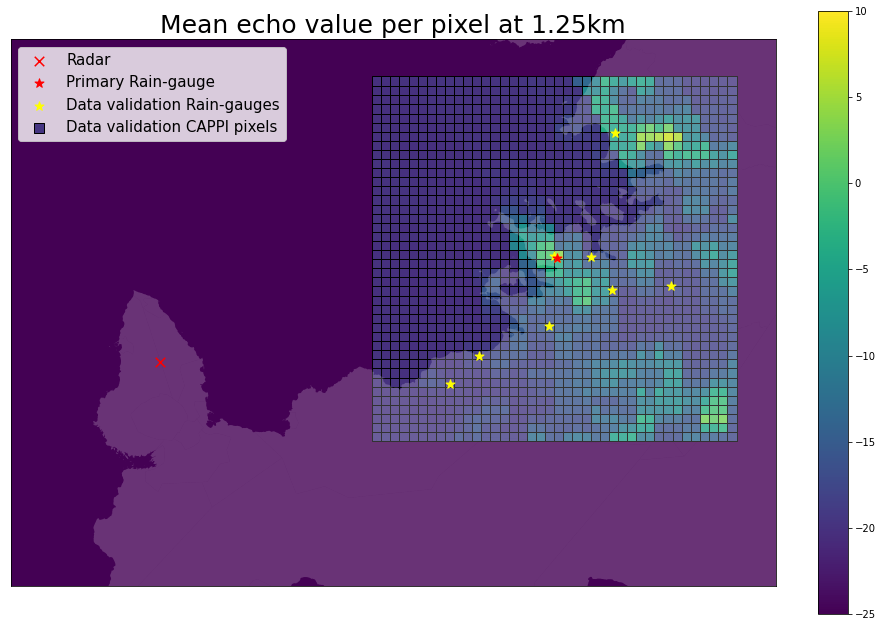

In [ ]:
margin_extra = 20
margin = 10
# margin = 30
gel_margin = 3

CAPPI_indexes = np.arange(602 ** 2).reshape(602, 602)

cappi_idx_extra = CAPPI_indexes[
    main_gauge_idx - margin_extra : main_gauge_idx + margin_extra,
    main_gauge_idy - margin_extra : main_gauge_idy + margin_extra,
].ravel()
cappi_idx = CAPPI_indexes[
    main_gauge_idx - margin : main_gauge_idx + margin,
    main_gauge_idy - margin : main_gauge_idy + margin,
].ravel()
cappi_idx_GEL = CAPPI_indexes[
    GEL_gauge_idx - gel_margin : GEL_gauge_idx + gel_margin,
    GEL_gauge_idy - gel_margin : GEL_gauge_idy + gel_margin,
].ravel()

plt.figure(figsize=(15, 15))
pixels_handle_extra = plt.scatter(
    coords[cappi_idx_extra, 0],
    coords[cappi_idx_extra, 1],
    s=100,
    marker="s",
    edgecolors="black",
    c=mean_echo_value_1_25km,
    vmin=-25,
    vmax=10,
)

plt.colorbar(fraction=0.036)
postnr.geometry.plot(ax=plt.gca(), alpha=0.2, color="white")

radar_handle = plt.scatter(radar_x, radar_y, c="red", marker="x", s=90)

pixel_idx = []
for index, row in df_meta_gauge.iterrows():
    gauge_x, gauge_y = transformer_gps_isl.transform(row["x"], -row["y"])
    gauge_handle_extra = plt.scatter(gauge_x, gauge_y, c="yellow", marker="*", s=90)
    gauge_idx, gauge_idy = get_idx_from_coords(coords, gauge_x, gauge_y)
    pixel_idx.append((gauge_idx, gauge_idy))


gauge_handle = plt.scatter(main_gauge_x, main_gauge_y, c="red", marker="*", s=90)
plt.ylim(main_gauge_y - 30_000, main_gauge_y + 20_000)
plt.xlim(main_gauge_x - 50_000, main_gauge_x + 20_000)
plt.xticks([], [])
plt.yticks([], [])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
plt.title("Mean echo value per pixel at 1.25km", fontsize=25)
plt.legend(
    [
        radar_handle,
        gauge_handle,
        gauge_handle_extra,
        # pixels_handle_GEL,
        # pixels_handle,
        pixels_handle_extra,
    ],
    [
        "Radar",
        "Primary Rain-gauge",
        "Data validation Rain-gauges",
        # "Pixels for Gelgjutangi test",
        # "Model input CAPPI pixels",
        "Data validation CAPPI pixels",
    ],
    loc="upper left",
    fontsize=15,
)
plt.show()


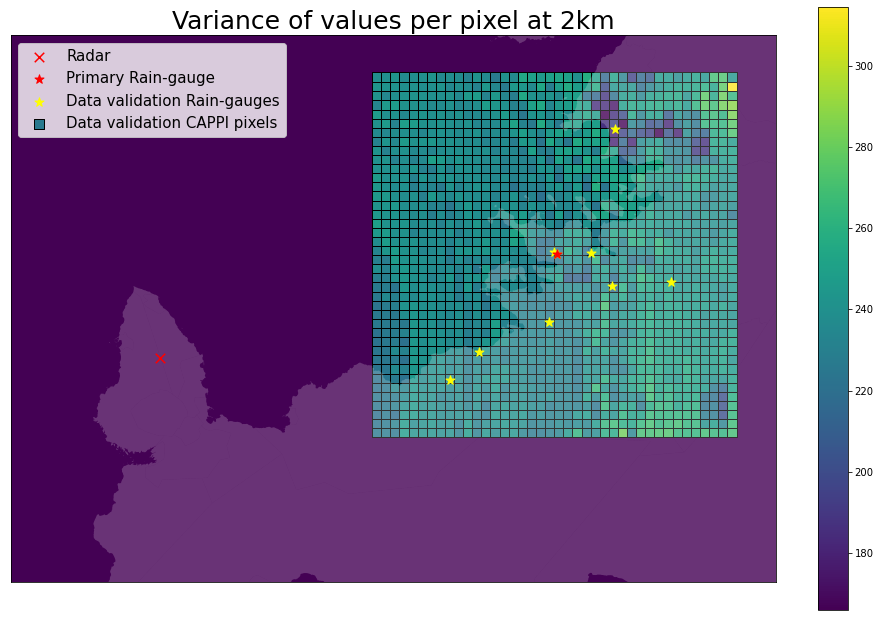

In [ ]:
margin_extra = 20
margin = 10
# margin = 30
gel_margin = 3

CAPPI_indexes = np.arange(602 ** 2).reshape(602, 602)

cappi_idx_extra = CAPPI_indexes[
    main_gauge_idx - margin_extra : main_gauge_idx + margin_extra,
    main_gauge_idy - margin_extra : main_gauge_idy + margin_extra,
].ravel()
cappi_idx = CAPPI_indexes[
    main_gauge_idx - margin : main_gauge_idx + margin,
    main_gauge_idy - margin : main_gauge_idy + margin,
].ravel()
cappi_idx_GEL = CAPPI_indexes[
    GEL_gauge_idx - gel_margin : GEL_gauge_idx + gel_margin,
    GEL_gauge_idy - gel_margin : GEL_gauge_idy + gel_margin,
].ravel()

plt.figure(figsize=(15, 15))
pixels_handle_extra = plt.scatter(
    coords[cappi_idx_extra, 0],
    coords[cappi_idx_extra, 1],
    s=100,
    marker="s",
    edgecolors="black",
    c=df_radar_1.var(axis=0).values,
    # vmin=-25,
    # vmax=10,
)

plt.colorbar(fraction=0.036)
postnr.geometry.plot(ax=plt.gca(), alpha=0.2, color="white")

radar_handle = plt.scatter(radar_x, radar_y, c="red", marker="x", s=90)

pixel_idx = []
for index, row in df_meta_gauge.iterrows():
    gauge_x, gauge_y = transformer_gps_isl.transform(row["x"], -row["y"])
    gauge_handle_extra = plt.scatter(gauge_x, gauge_y, c="yellow", marker="*", s=90)
    gauge_idx, gauge_idy = get_idx_from_coords(coords, gauge_x, gauge_y)
    pixel_idx.append((gauge_idx, gauge_idy))


gauge_handle = plt.scatter(main_gauge_x, main_gauge_y, c="red", marker="*", s=90)
plt.ylim(main_gauge_y - 30_000, main_gauge_y + 20_000)
plt.xlim(main_gauge_x - 50_000, main_gauge_x + 20_000)
plt.xticks([], [])
plt.yticks([], [])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
plt.title("Variance of values per pixel at 2km", fontsize=25)
plt.legend(
    [
        radar_handle,
        gauge_handle,
        gauge_handle_extra,
        # pixels_handle_GEL,
        # pixels_handle,
        pixels_handle_extra,
    ],
    [
        "Radar",
        "Primary Rain-gauge",
        "Data validation Rain-gauges",
        # "Pixels for Gelgjutangi test",
        # "Model input CAPPI pixels",
        "Data validation CAPPI pixels",
    ],
    loc="upper left",
    fontsize=15,
)
plt.show()
